# 0.0. Imports

In [1]:
import pandas     as pd
import numpy      as np
import seaborn    as sns
import inflection
import pickle

from sklearn.model_selection import train_test_split
from sklearn.ensemble        import RandomForestRegressor
from sklearn.neighbors       import KNeighborsClassifier
from sklearn.linear_model    import LogisticRegression
from sklearn.tree            import DecisionTreeClassifier
from sklearn.metrics         import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.metrics         import roc_curve, roc_auc_score, precision_recall_curve , auc

from tabulate                import tabulate
from matplotlib              import pyplot as plt
from IPython.display         import Image
from IPython.core.display    import HTML
from boruta                  import BorutaPy

## 0.1. Helper Functions

In [2]:
def jupyter_settings():
    %matplotlib inline
    %pylab inline
    
    plt.style.use( 'bmh' )
    plt.rcParams['figure.figsize'] = [25, 12]
    plt.rcParams['font.size'] = 24
    
    display( HTML( '<style>.container { width:100% !important; }</style>') )
    pd.options.display.max_columns = None
    pd.options.display.max_rows = None
    pd.set_option( 'display.expand_frame_repr', False )
    
    sns.set()

In [3]:
jupyter_settings()

%pylab is deprecated, use %matplotlib inline and import the required libraries.
Populating the interactive namespace from numpy and matplotlib


## 0.2. Loading Data

In [4]:
# Importando Dataset's
df = pd.read_csv(r'C:\Users\usuario\Documents\projetos\PA_001\dataset\cardio_train.csv', delimiter=';')

In [5]:
df.head()

,id,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio
0,0,18393,2,168,62.0,110,80,1,1,0,0,1,0
1,1,20228,1,156,85.0,140,90,3,1,0,0,1,1
2,2,18857,1,165,64.0,130,70,3,1,0,0,0,1
3,3,17623,2,169,82.0,150,100,1,1,0,0,1,1
4,4,17474,1,156,56.0,100,60,1,1,0,0,0,0


# 1.0. Data Cleaning

In [6]:
df1 = df.copy()

## 1.1. Data Dimension

In [7]:
# Visão geral das colunas
df1.columns

Index(['id', 'age', 'gender', 'height', 'weight', 'ap_hi', 'ap_lo',
       'cholesterol', 'gluc', 'smoke', 'alco', 'active', 'cardio'],
      dtype='object')

In [8]:
# Validando tamanho do Dataset
print('Number Of Rows: {}' .format(df1.shape[0]))
print('Number Of Columns: {}' .format(df1.shape[1]))

Number Of Rows: 50000
Number Of Columns: 13


## 1.2. Data Type

In [9]:
df1.dtypes

id               int64
age              int64
gender           int64
height           int64
weight         float64
ap_hi            int64
ap_lo            int64
cholesterol      int64
gluc             int64
smoke            int64
alco             int64
active           int64
cardio           int64
dtype: object

In [10]:
# Ajustando casas decimais
df1['weight'] = df1['weight'].round()

## 1.3. Data N/A's

In [11]:
# Função que identifica e soma a quantidade de N/A's
df1.isna().sum()

id             0
age            0
gender         0
height         0
weight         0
ap_hi          0
ap_lo          0
cholesterol    0
gluc           0
smoke          0
alco           0
active         0
cardio         0
dtype: int64

# 2.0. Descriptive data analysis

In [12]:
df2 = df1.copy()

### 2.0.1. Replacing Erros's

In [13]:
# Verificar o comprimento dos valores na coluna 'ap_hi'
comprimentos = df2['ap_hi'].astype(str).str.len()

# Tratamento len = 1
df2.loc[comprimentos == 1, 'ap_hi'] = df2.loc[comprimentos == 1, 'ap_hi'] * 10

# Tratamento len = 2
df2.loc[comprimentos == 2, 'ap_hi'] = (df2.loc[comprimentos == 2, 'ap_hi'] // 10).round() * 10

# Tratamento len = 3
df2.loc[comprimentos == 3, 'ap_hi'] = (df2.loc[comprimentos == 3, 'ap_hi'] // 10).round() * 10

# Tratamento len = 4
df2.loc[comprimentos == 4, 'ap_hi'] = (df2.loc[comprimentos == 4, 'ap_hi'] // 100).round() * 10

# Tratamento len = 5
df2.loc[comprimentos == 5, 'ap_hi'] = (df2.loc[comprimentos == 5, 'ap_hi'] // 1000).round() * 10

# Verificar o comprimento dos valores na coluna 'ap_li'
comprimentos = df2['ap_lo'].astype(str).str.len()

# Tratamento len = 1
df2.loc[comprimentos == 1, 'ap_lo'] = df2.loc[comprimentos == 1, 'ap_lo'] * 10

# Tratamento len = 2
df2.loc[comprimentos == 2, 'ap_lo'] = (df2.loc[comprimentos == 2, 'ap_lo'] // 10).round() * 10

# Tratamento len = 3
df2.loc[comprimentos == 3, 'ap_lo'] = (df2.loc[comprimentos == 3, 'ap_lo'] // 10).round() * 10

# Tratamento len = 4
df2.loc[comprimentos == 4, 'ap_lo'] = (df2.loc[comprimentos == 4, 'ap_lo'] // 100).round() * 10

# Tratamento len = 5
df2.loc[comprimentos == 5, 'ap_lo'] = (df2.loc[comprimentos == 5, 'ap_lo'] // 1000).round() * 10

## 2.1. Atribute Separation

In [14]:
# Separando as variáveis em Númericas e Categóricas
num_attributes = df2.drop(['id', 'gender', 'cholesterol', 'gluc', 'smoke', 'alco', 'active', 'cardio'], axis=1)
cat_attributes = df2.drop(['age', 'height', 'weight', 'ap_hi', 'ap_lo'], axis=1)

## 2.2. Identifying outliers

### 2.2.1. Boxplot's

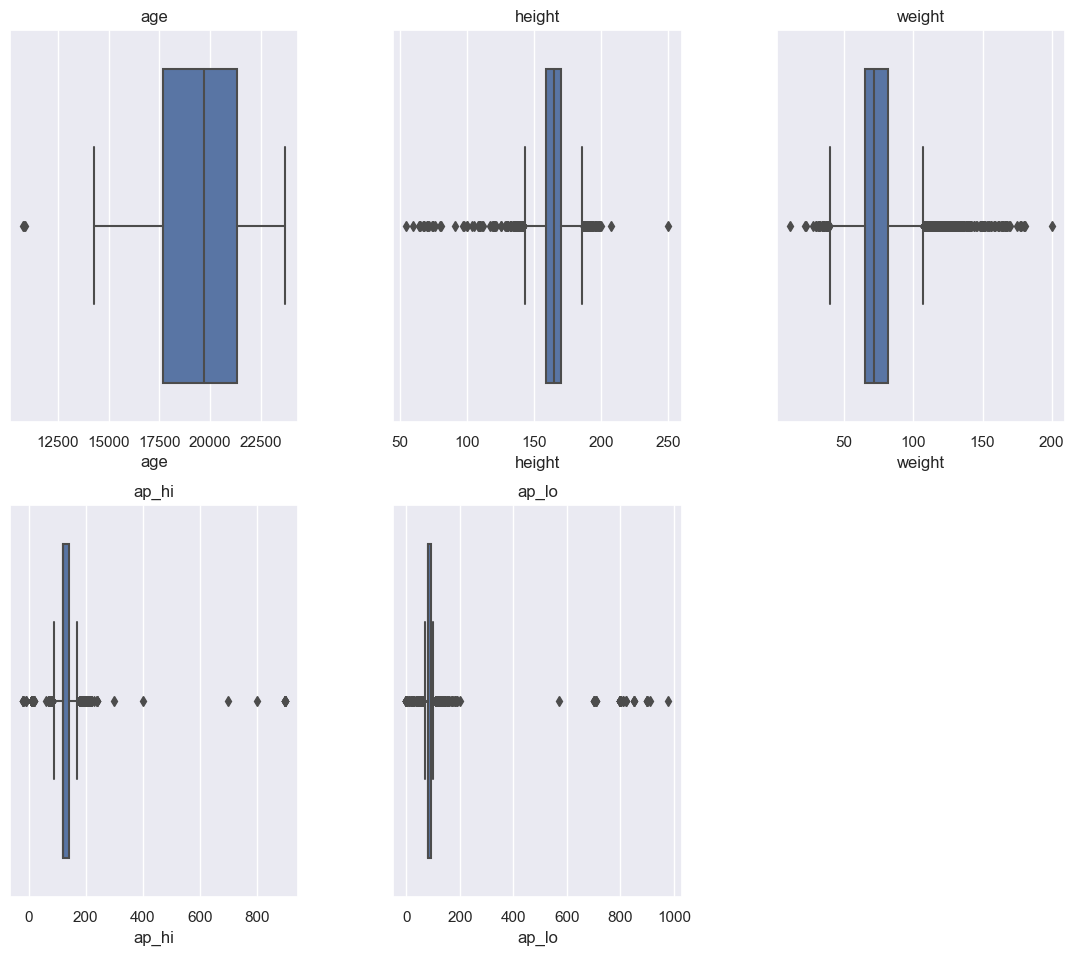

In [15]:
# Calcular o número de colunas e linhas da grade
num_cols = len(num_attributes.columns)
num_rows = 2

# Criar a matriz de subplots
fig, axes = plt.subplots(num_rows, 3, figsize=(12, 10))

# Ajustar o espaçamento entre os subplots
fig.tight_layout(pad=3.0)

# Plotar os boxplots em cada subplot
for i, column in enumerate(num_attributes.columns):
    row = i // 3
    col = i % 3
    ax = axes[row, col]
    sns.boxplot(data=num_attributes, x=column, ax=ax)
    ax.set_title(column)

# Remover o último subplot da 2ª linha (posição [1, 2])
fig.delaxes(axes[1, 2])

# Exibir o gráfico
plt.show()

### 2.2.2. Lower/Upper Limit

In [16]:
# Convertendo a coluna age em ano e removendo do dataframe desconsiderando da análise de outlier's 
num_attributes['age'] = (num_attributes['age'] / 365).round().astype('int64')

In [17]:
# Lista para armazenar os resultados
results = []

# Itera sobre as colunas do DataFrame
for column in num_attributes.columns:
    # Calcula os quartis
    min =  num_attributes[column].min()
    max =  num_attributes[column].max()
    mean = num_attributes[column].mean().round()
    q1 = num_attributes[column].quantile(0.25)
    q3 = num_attributes[column].quantile(0.75)

    # Calcula o IQR
    iqr = q3 - q1

    # Calcula os limites inferior e superior
    lower_limit = q1 - 1.5 * iqr
    upper_limit = q3 + 1.5 * iqr

    # Filtra os valores que estão abaixo do limite inferior e acima do limite superior
    outliers_below = num_attributes[num_attributes[column] < lower_limit]
    outliers_above = num_attributes[num_attributes[column] > upper_limit]

    # Conta a quantidade de outliers abaixo e acima dos limites
    count_below = len(outliers_below)
    count_above = len(outliers_above)

    # Cria um dicionário com os resultados
    result = {
        'Feature': column,
        'Mínimo': min,
        'Máximo': max,
        'Média': mean,
        'Limite Inferior': lower_limit,
        'Limite Superior': upper_limit,
        'Outliers abaixo': count_below,
        'Outliers acima': count_above
    }

    # Adiciona o dicionário à lista de resultados
    results.append(result)

# Cria um DataFrame com os resultados
results_df = pd.DataFrame(results)

# Exibe a tabela de resultados
results_df

,Feature,Mínimo,Máximo,Média,Limite Inferior,Limite Superior,Outliers abaixo,Outliers acima
0,age,30.0,65.0,53.0,33.0,73.0,3,0
1,height,55.0,250.0,164.0,142.5,186.5,178,193
2,weight,11.0,200.0,74.0,39.5,107.5,35,1247
3,ap_hi,-20.0,900.0,127.0,90.0,170.0,230,765
4,ap_lo,0.0,980.0,82.0,65.0,105.0,2241,709


### 2.2.3. Outlier analysis

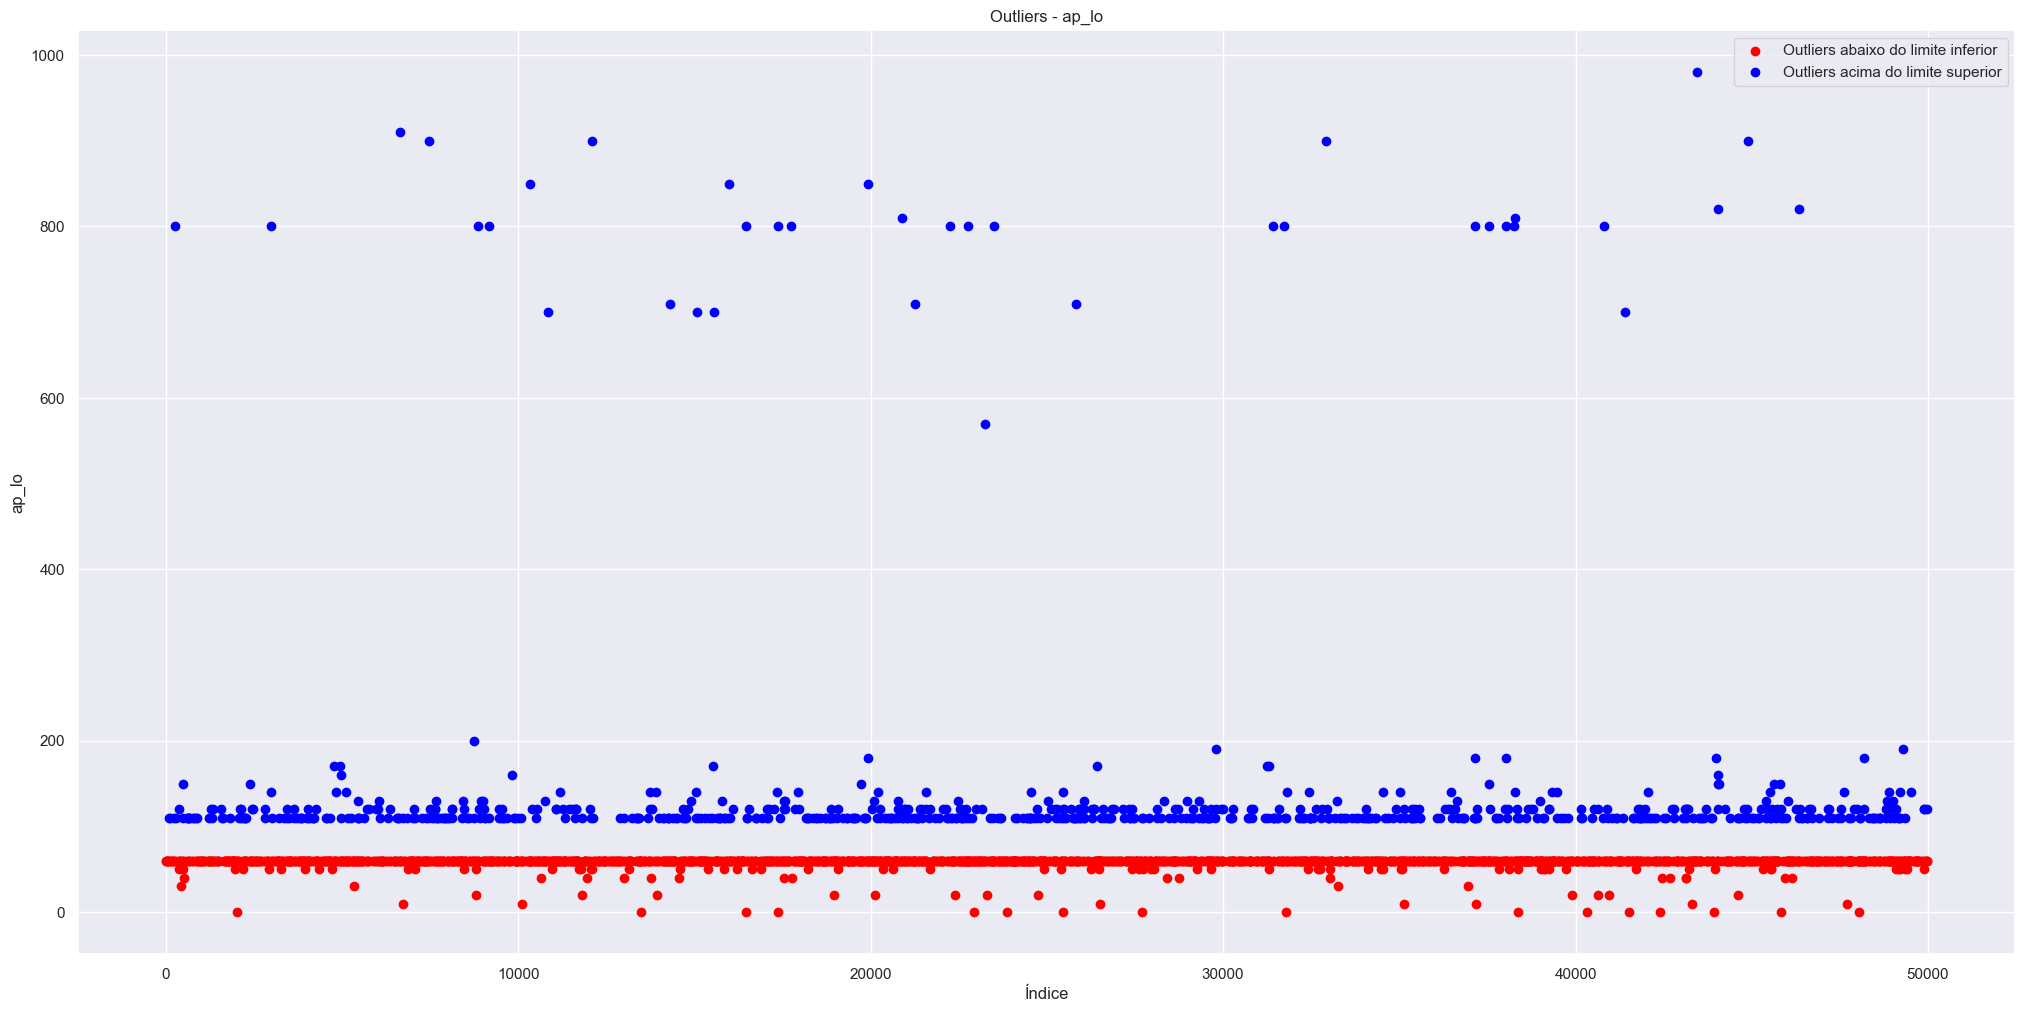

In [18]:
# Filtra os outliers abaixo do limite inferior
outliers_below_age = num_attributes[num_attributes['ap_lo'] < results_df.loc[results_df['Feature'] == 'ap_lo', 'Limite Inferior'].values[0]]

# Filtra os outliers acima do limite superior
outliers_above_age = num_attributes[num_attributes['ap_lo'] > results_df.loc[results_df['Feature'] == 'ap_lo', 'Limite Superior'].values[0]]

# Cria o gráfico de dispersão com os outliers abaixo do limite inferior e acima do limite superior
plt.scatter(outliers_below_age.index, outliers_below_age['ap_lo'], color='red', label='Outliers abaixo do limite inferior')
plt.scatter(outliers_above_age.index, outliers_above_age['ap_lo'], color='blue', label='Outliers acima do limite superior')
plt.xlabel('Índice')
plt.ylabel('ap_lo')
plt.title('Outliers - ap_lo')
plt.legend()
plt.show()

### 2.2.4. Replacing outliers

In [19]:
# Definir os limites das faixas etárias
age_bins = [30, 35, 40, 45, 50, 55, 60, 65, np.inf]

# Definir os rótulos das faixas etárias
age_labels = ['30-34', '35-39', '40-44', '45-49', '50-54', '55-59', '60-64', '65-70']

# Adicionar uma nova coluna com as faixas etárias correspondentes
num_attributes['age_group'] = pd.cut(num_attributes['age'], bins=age_bins, labels=age_labels, right=False)

In [20]:
# Limites coluna height
lower_limit = 145
upper_limit = 200

# função para substituir os valores fora do limite pela mediana da faixa etária correspondente
def replace_outliers_height(row):
    if row['height'] < lower_limit or row['height'] > upper_limit:
        median_height = num_attributes.loc[num_attributes['age_group'] == row['age_group'], 'height'].median()
        return median_height
    return row['height']

# Aplicando função
num_attributes['height'] = num_attributes.apply(replace_outliers_height, axis=1)

In [21]:
# Limites coluna weight
lower_limit = 40.00
upper_limit = 135.00

# função para substituir os valores fora do limite pela mediana da faixa etária correspondente
def replace_outliers_weight(row):
    if row['weight'] < lower_limit or row['weight'] > upper_limit:
        median_weight = num_attributes.loc[num_attributes['age_group'] == row['age_group'], 'weight'].median()
        return median_weight
    return row['weight']

# Aplicando função
num_attributes['weight'] = num_attributes.apply(replace_outliers_weight, axis=1)

In [22]:
# Limites coluna ap_hi
lower_limit = 70
upper_limit = 300

# função para substituir os valores fora do limite pela mediana da faixa etária correspondente
def replace_outliers_ap_hi(row):
    if row['ap_hi'] < lower_limit or row['ap_hi'] > upper_limit:
        median_ap_hi = num_attributes.loc[num_attributes['age_group'] == row['age_group'], 'ap_hi'].median()
        return median_ap_hi
    return row['ap_hi']

# Aplicando função
num_attributes['ap_hi'] = num_attributes.apply(replace_outliers_ap_hi, axis=1)

In [23]:
# Limites coluna ap_lo
lower_limit = 50
upper_limit = 200

# função para substituir os valores fora do limite pela mediana da faixa etária correspondente
def replace_outliers_ap_lo(row):
    if row['ap_lo'] < lower_limit or row['ap_lo'] > upper_limit:
        median_ap_lo = num_attributes.loc[num_attributes['age_group'] == row['age_group'], 'ap_lo'].median()
        return median_ap_lo
    return row['ap_lo']

# Aplicando função
num_attributes['ap_lo'] = num_attributes.apply(replace_outliers_ap_lo, axis=1)

### 2.2.5. Validating replacement outliers

In [24]:
num_attributes = num_attributes.drop('age_group', axis=1)

In [25]:
# Lista para armazenar os resultados
results = []

# Itera sobre as colunas do DataFrame
for column in num_attributes.columns:
    # Calcula os quartis
    min =  num_attributes[column].min()
    max =  num_attributes[column].max()
    mean = num_attributes[column].mean().round()
    q1 = num_attributes[column].quantile(0.25)
    q3 = num_attributes[column].quantile(0.75)

    # Calcula o IQR
    iqr = q3 - q1

    # Calcula os limites inferior e superior
    lower_limit = q1 - 1.5 * iqr
    upper_limit = q3 + 1.5 * iqr

    # Filtra os valores que estão abaixo do limite inferior e acima do limite superior
    outliers_below = num_attributes[num_attributes[column] < lower_limit]
    outliers_above = num_attributes[num_attributes[column] > upper_limit]

    # Conta a quantidade de outliers abaixo e acima dos limites
    count_below = len(outliers_below)
    count_above = len(outliers_above)

    # Cria um dicionário com os resultados
    result = {
        'Feature': column,
        'Mínimo': min,
        'Máximo': max,
        'Média': mean,
        'Limite Inferior': lower_limit,
        'Limite Superior': upper_limit,
        'Outliers abaixo': count_below,
        'Outliers acima': count_above
    }

    # Adiciona o dicionário à lista de resultados
    results.append(result)

# Cria um DataFrame com os resultados
results_df = pd.DataFrame(results)

# Exibe a tabela de resultados
results_df

,Feature,Mínimo,Máximo,Média,Limite Inferior,Limite Superior,Outliers abaixo,Outliers acima
0,age,30.0,65.0,53.0,33.0,73.0,3,0
1,height,145.0,200.0,165.0,142.5,186.5,0,191
2,weight,40.0,135.0,74.0,39.5,107.5,0,1148
3,ap_hi,70.0,300.0,127.0,90.0,170.0,94,753
4,ap_lo,50.0,200.0,81.0,65.0,105.0,2185,671


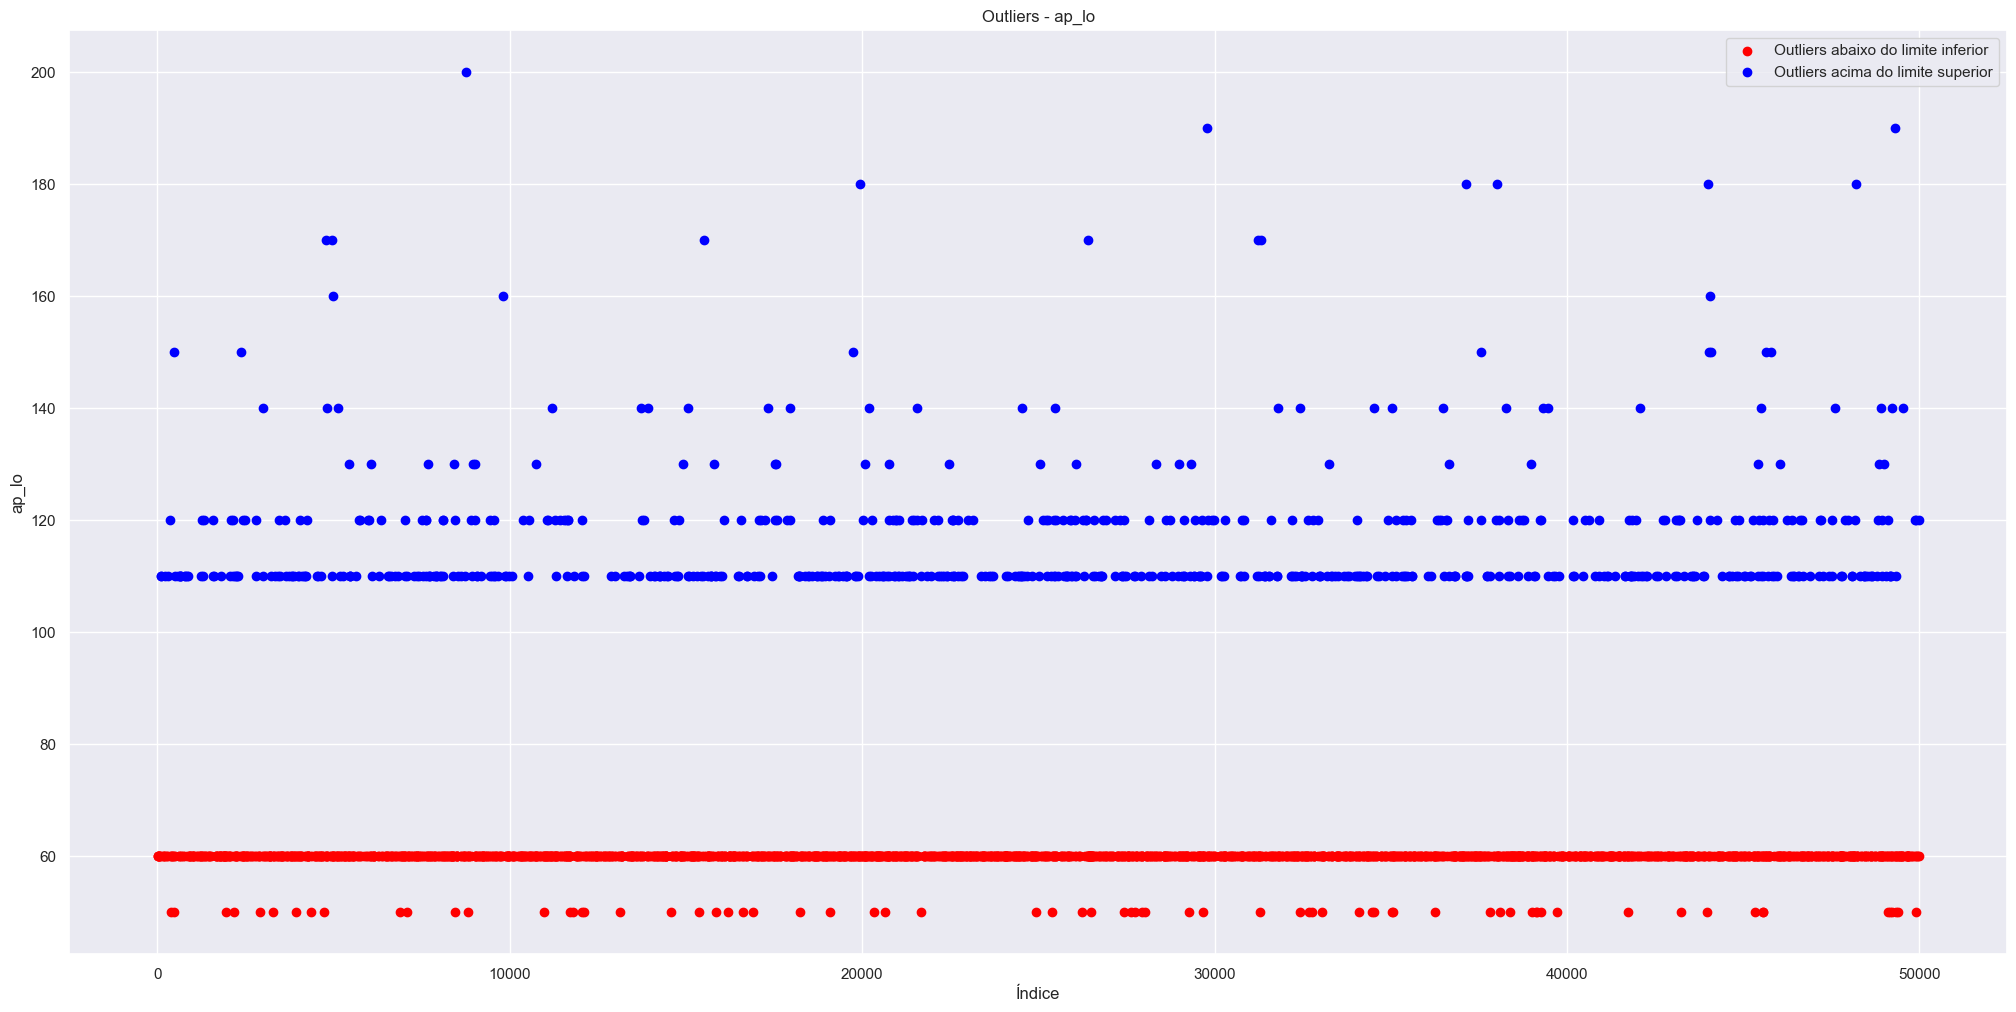

In [26]:
# Filtra os outliers abaixo do limite inferior
outliers_below_age = num_attributes[num_attributes['ap_lo'] < results_df.loc[results_df['Feature'] == 'ap_lo', 'Limite Inferior'].values[0]]

# Filtra os outliers acima do limite superior
outliers_above_age = num_attributes[num_attributes['ap_lo'] > results_df.loc[results_df['Feature'] == 'ap_lo', 'Limite Superior'].values[0]]

# Cria o gráfico de dispersão com os outliers abaixo do limite inferior e acima do limite superior
plt.scatter(outliers_below_age.index, outliers_below_age['ap_lo'], color='red', label='Outliers abaixo do limite inferior')
plt.scatter(outliers_above_age.index, outliers_above_age['ap_lo'], color='blue', label='Outliers acima do limite superior')
plt.xlabel('Índice')
plt.ylabel('ap_lo')
plt.title('Outliers - ap_lo')
plt.legend()
plt.show()

## 2.3. Numerical Atributes

In [27]:
# Convertendo a coluna age em dias
num_attributes['age'] = (num_attributes['age'] * 365).round().astype('int64')

In [28]:
num_attributes.dtypes

age         int64
height    float64
weight    float64
ap_hi     float64
ap_lo     float64
dtype: object

In [29]:
# Central Tendency - mean, meadiana 
ct1 = pd.DataFrame( num_attributes.apply( np.mean ) ).T
ct2 = pd.DataFrame( num_attributes.apply( np.median ) ).T

# dispersion - std, min, max, range, skew, kurtosis
d1 = pd.DataFrame( num_attributes.apply( np.std ) ).T 
d2 = pd.DataFrame(num_attributes.apply(lambda x: x.min(), axis=0)).T 
d3 = pd.DataFrame(num_attributes.apply(lambda x: x.max(), axis=0)).T
d4 = pd.DataFrame( num_attributes.apply( lambda x: x.max() - x.min() ) ).T 
d5 = pd.DataFrame( num_attributes.apply( lambda x: x.skew() ) ).T 
d6 = pd.DataFrame( num_attributes.apply( lambda x: x.kurtosis() ) ).T 

# concatenar
m = pd.concat( [d2, d3, d4, ct1, ct2, d1, d5, d6] ).T.reset_index()
m.columns = ['attributes', 'min', 'max', 'range', 'mean', 'median', 'std', 'skew', 'kurtosis']
m

,attributes,min,max,range,mean,median,std,skew,kurtosis
0,age,10950.0,23725.0,12775.0,19465.01930,19710.0,2470.200094,-0.307987,-0.820548
1,height,145.0,200.0,55.0,164.53480,165.0,7.691545,0.211541,-0.003702
2,weight,40.0,135.0,95.0,74.09868,72.0,13.846271,0.775011,0.916447
3,ap_hi,70.0,300.0,230.0,126.83100,120.0,17.094193,0.933167,1.977310
4,ap_lo,50.0,200.0,150.0,81.49840,80.0,10.005938,0.756256,4.643254


## 2.4. Categorical Atributes

In [30]:
# Verificando qtd de valores Únicos
aux = cat_attributes.apply( lambda x: x.unique().shape[0] )
aux

id             50000
gender             2
cholesterol        3
gluc               3
smoke              2
alco               2
active             2
cardio             2
dtype: int64

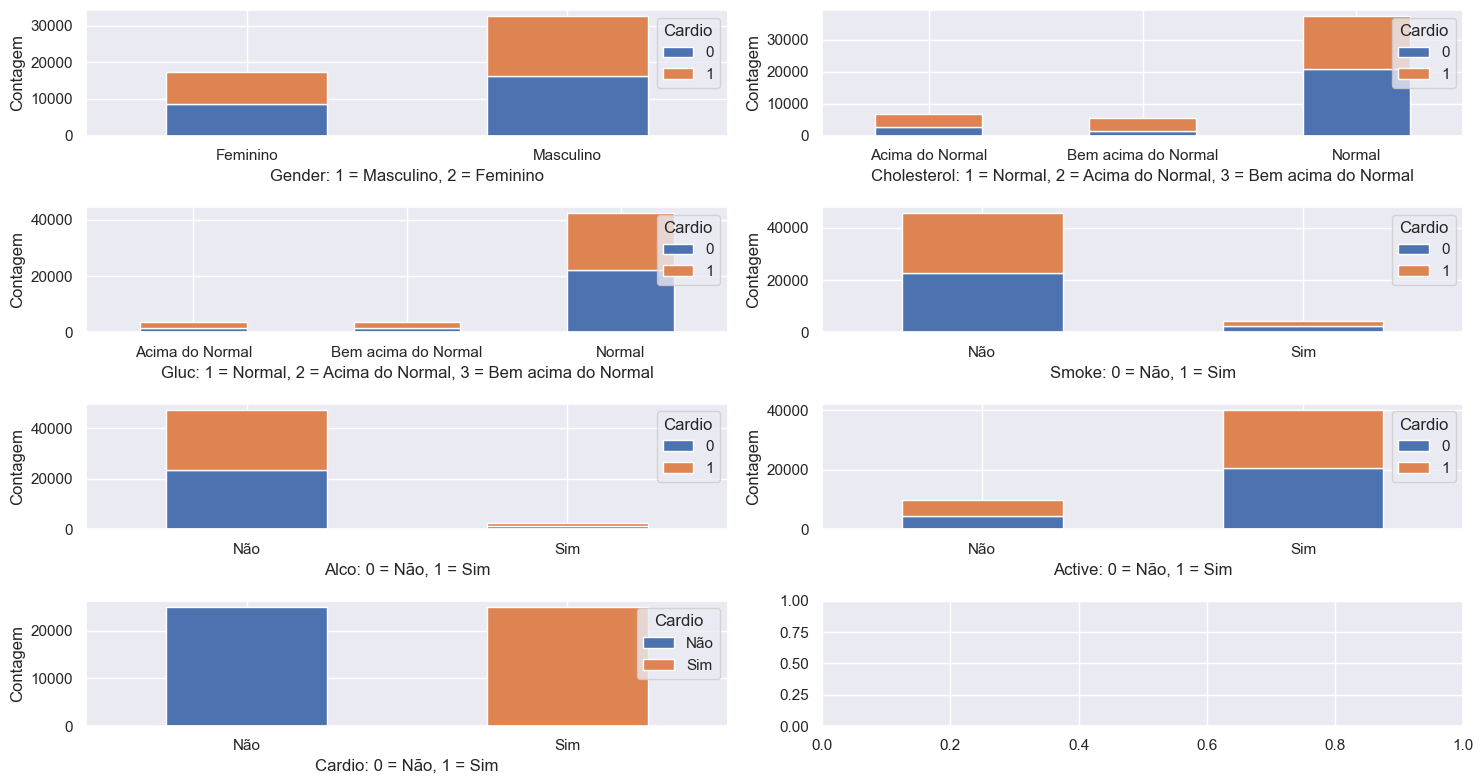

In [31]:
# Mapeamento das legendas para as variáveis categóricas
legend_map = {
    'gender': {1: 'Masculino', 2: 'Feminino'},
    'alco': {0: 'Não', 1: 'Sim'},
    'active': {0: 'Não', 1: 'Sim'},
    'smoke': {0: 'Não', 1: 'Sim'},
    'cholesterol': {1: 'Normal', 2: 'Acima do Normal', 3: 'Bem acima do Normal'},
    'gluc': {1: 'Normal', 2: 'Acima do Normal', 3: 'Bem acima do Normal'},
    'cardio': {0: 'Não', 1: 'Sim'}  # Atualização da legenda para a variável 'cardio'
}

# Lista das variáveis categóricas
categorical_vars = ['gender', 'cholesterol', 'gluc', 'smoke', 'alco', 'active', 'cardio']  # Inclusão da variável 'cardio'

# Definir a quantidade de linhas e colunas para os subplots
n_cols = len(categorical_vars)
n_rows = n_cols // 2 if n_cols % 2 == 0 else n_cols // 2 + 1

# Criar a grade de subplots
fig, axes = plt.subplots(n_rows, 2, figsize=(15, 8))

# Iterar sobre as variáveis categóricas e plotar os gráficos de barras empilhadas
for i, var in enumerate(categorical_vars):
    # Criar uma tabela de contingência
    contingency_table = pd.crosstab(cat_attributes[var].map(legend_map[var]), cat_attributes['cardio'])
    
    # Plotar o gráfico de barras empilhadas no subplot correspondente
    ax = axes[i // 2, i % 2]
    contingency_table.plot(kind='bar', stacked=True, ax=ax)
    
    ax.set_xlabel(f'{var.capitalize()}: {", ".join(f"{k} = {v}" for k, v in legend_map[var].items())}')
    ax.set_ylabel('Contagem')
    
    if var == 'cardio':
        ax.legend(title='Cardio', loc='upper right', labels=['Não', 'Sim'])  # Atualização da legenda para 'cardio'
    else:
        ax.legend(title='Cardio', loc='upper right')
    
    # Girar os rótulos do eixo x horizontalmente
    ax.set_xticklabels(ax.get_xticklabels(), rotation=0)
    
# Ajustar o espaçamento entre os subplots
plt.tight_layout()

# Exibir o gráfico
plt.show()

## 2.5. Merge

In [32]:
# Realizando merge entre os dataframes
df25 = pd.concat([num_attributes, cat_attributes], axis=1)

In [33]:
df25.columns

Index(['age', 'height', 'weight', 'ap_hi', 'ap_lo', 'id', 'gender',
       'cholesterol', 'gluc', 'smoke', 'alco', 'active', 'cardio'],
      dtype='object')

# 3.0. Feature Engineering

In [34]:
# Criando uma cópia do último Capítulo
df3 = df25.copy()

## 3.1. Mindmap

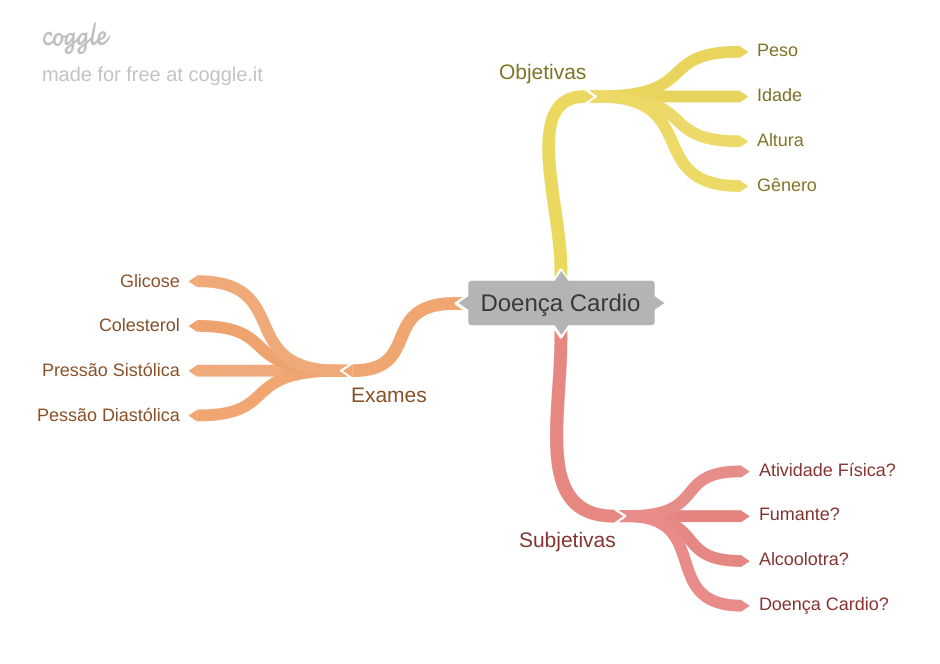

In [35]:
Image(r'C:\Users\usuario\Documents\projetos\PA_001\images\cardio.png')

## 3.2. Hypothesis Creation

## 3.3. Extract new features

In [36]:
# Criação da nova coluna [IMC]
df3['imc'] = (df3['weight'] / ((df3['height'] / 100) ** 2)).round(2)

# Criação da nova coluna idade em anos [age_year]
df3['age_year'] = (df3['age'] / 365).round().astype('int64')

# Criação da nova coluna de classificação da obesidade [obesity_class]
df3['obesity_class'] = pd.cut(df3['imc'], bins=[-float('inf'), 18.5, 24.9, 29.9, 34.9, 39.9, float('inf')],
                             labels=[-1, 0, 1, 2, 3, 4]).astype('int64')

# Definir as faixas de pressão arterial por idade
age_bins = [0, 18, 30, 40, 50, 60, np.inf]
pressure_bins = [[85, 130], [85, 130], [90, 140], [100, 160], [110, 180], [90, 140]]

# Função para classificar a pressão arterial
def classify_pressure(row):
    age = row['age_year']
    sys_pressure = row['ap_hi']
    dia_pressure = row['ap_lo']
    
    # Encontrar a faixa etária correspondente
    age_group = pd.cut([age], bins=age_bins, labels=False, right=False)[0]
    
    # Encontrar a classificação da pressão arterial
    pressure_class = 0
    sys_min, sys_max = pressure_bins[age_group]
    dia_min, dia_max = pressure_bins[age_group]
    if sys_min <= sys_pressure <= sys_max and dia_min <= dia_pressure <= dia_max:
        pressure_class = 1
    
    return pressure_class

# Criar a nova coluna de classificação da pressão arterial
df3['pressure_class'] = df3.apply(classify_pressure, axis=1)

df3.head()

,age,height,weight,ap_hi,ap_lo,id,gender,cholesterol,gluc,smoke,alco,active,cardio,imc,age_year,obesity_class,pressure_class
0,18250,168.0,62.0,110.0,80.0,0,2,1,1,0,0,1,0,21.97,50,0,0
1,20075,156.0,85.0,140.0,90.0,1,1,3,1,0,0,1,1,34.93,55,3,0
2,18980,165.0,64.0,130.0,70.0,2,1,3,1,0,0,0,1,23.51,52,0,0
3,17520,169.0,82.0,150.0,100.0,3,2,1,1,0,0,1,1,28.71,48,1,1
4,17520,156.0,56.0,100.0,60.0,4,1,1,1,0,0,0,0,23.01,48,0,0


# 4.0. Analysis Exploratory

In [37]:
df4 = df3.copy()

## 4.1. Univariate Analysis

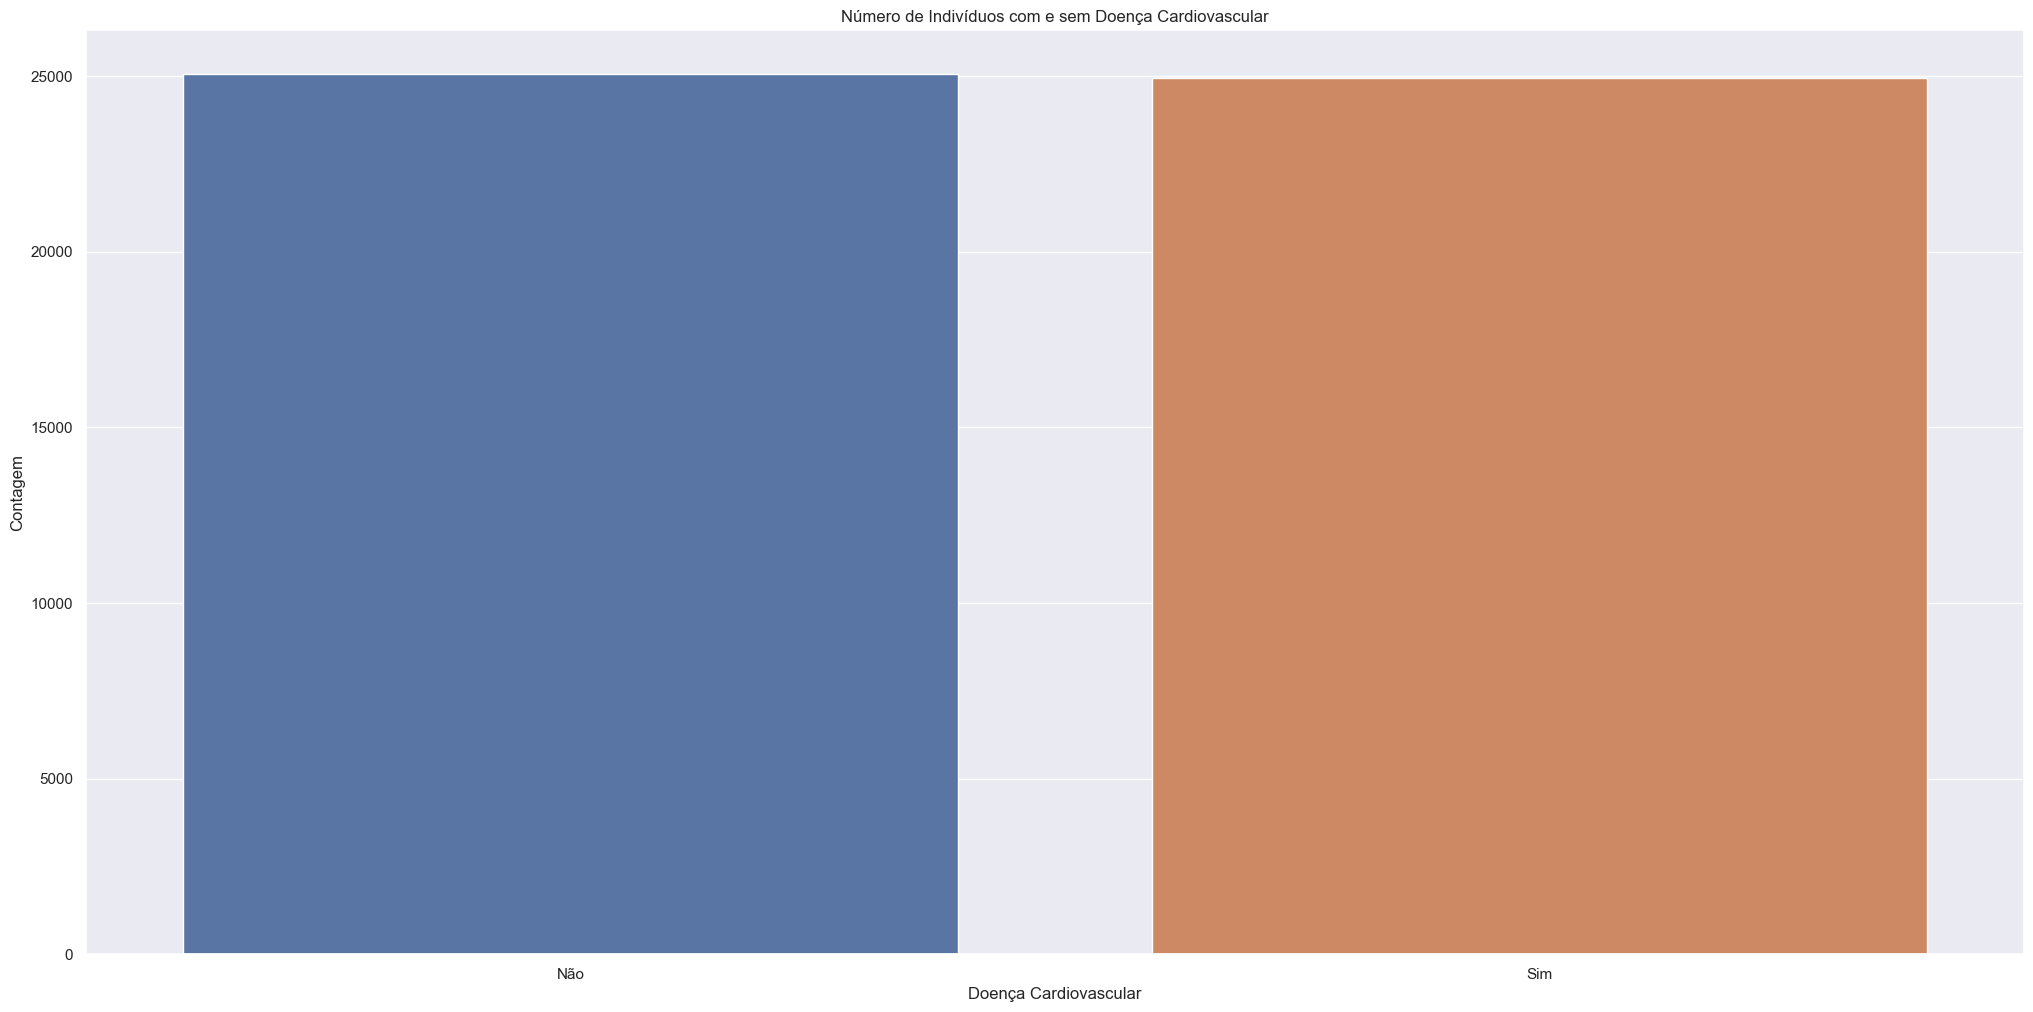

In [38]:
# Cópia Dataframe
df_41 = df4.copy()

# Tabela de contagem de 'cardio'
count_table = df_41['cardio'].value_counts()

# Plotar gráfico de barras
sns.barplot(x=count_table.index, y=count_table.values)

# Configurar rótulos personalizados para os valores do eixo x
plt.xticks([0, 1], ['Não', 'Sim'])

# Configurações adicionais do gráfico
plt.xlabel('Doença Cardiovascular')
plt.ylabel('Contagem')
plt.title('Número de Indivíduos com e sem Doença Cardiovascular')

# Exibir o gráfico
plt.show()

## 4.2. Bivariate Analysis

### 4.2.1. [1] Pessoas acima de 50 anos apresentam maior incidência de Doença Cardio.

[VERDADEIRA] Sim, sendo a faixa etária de 60-64 anos com maior quantidade de pessoas.

In [39]:
# Verificando range de faixa etária
min = df4['age_year'].min()
max = df4['age_year'].max()

print(f'minimo: {min}, max: {max}')

minimo: 30, max: 65


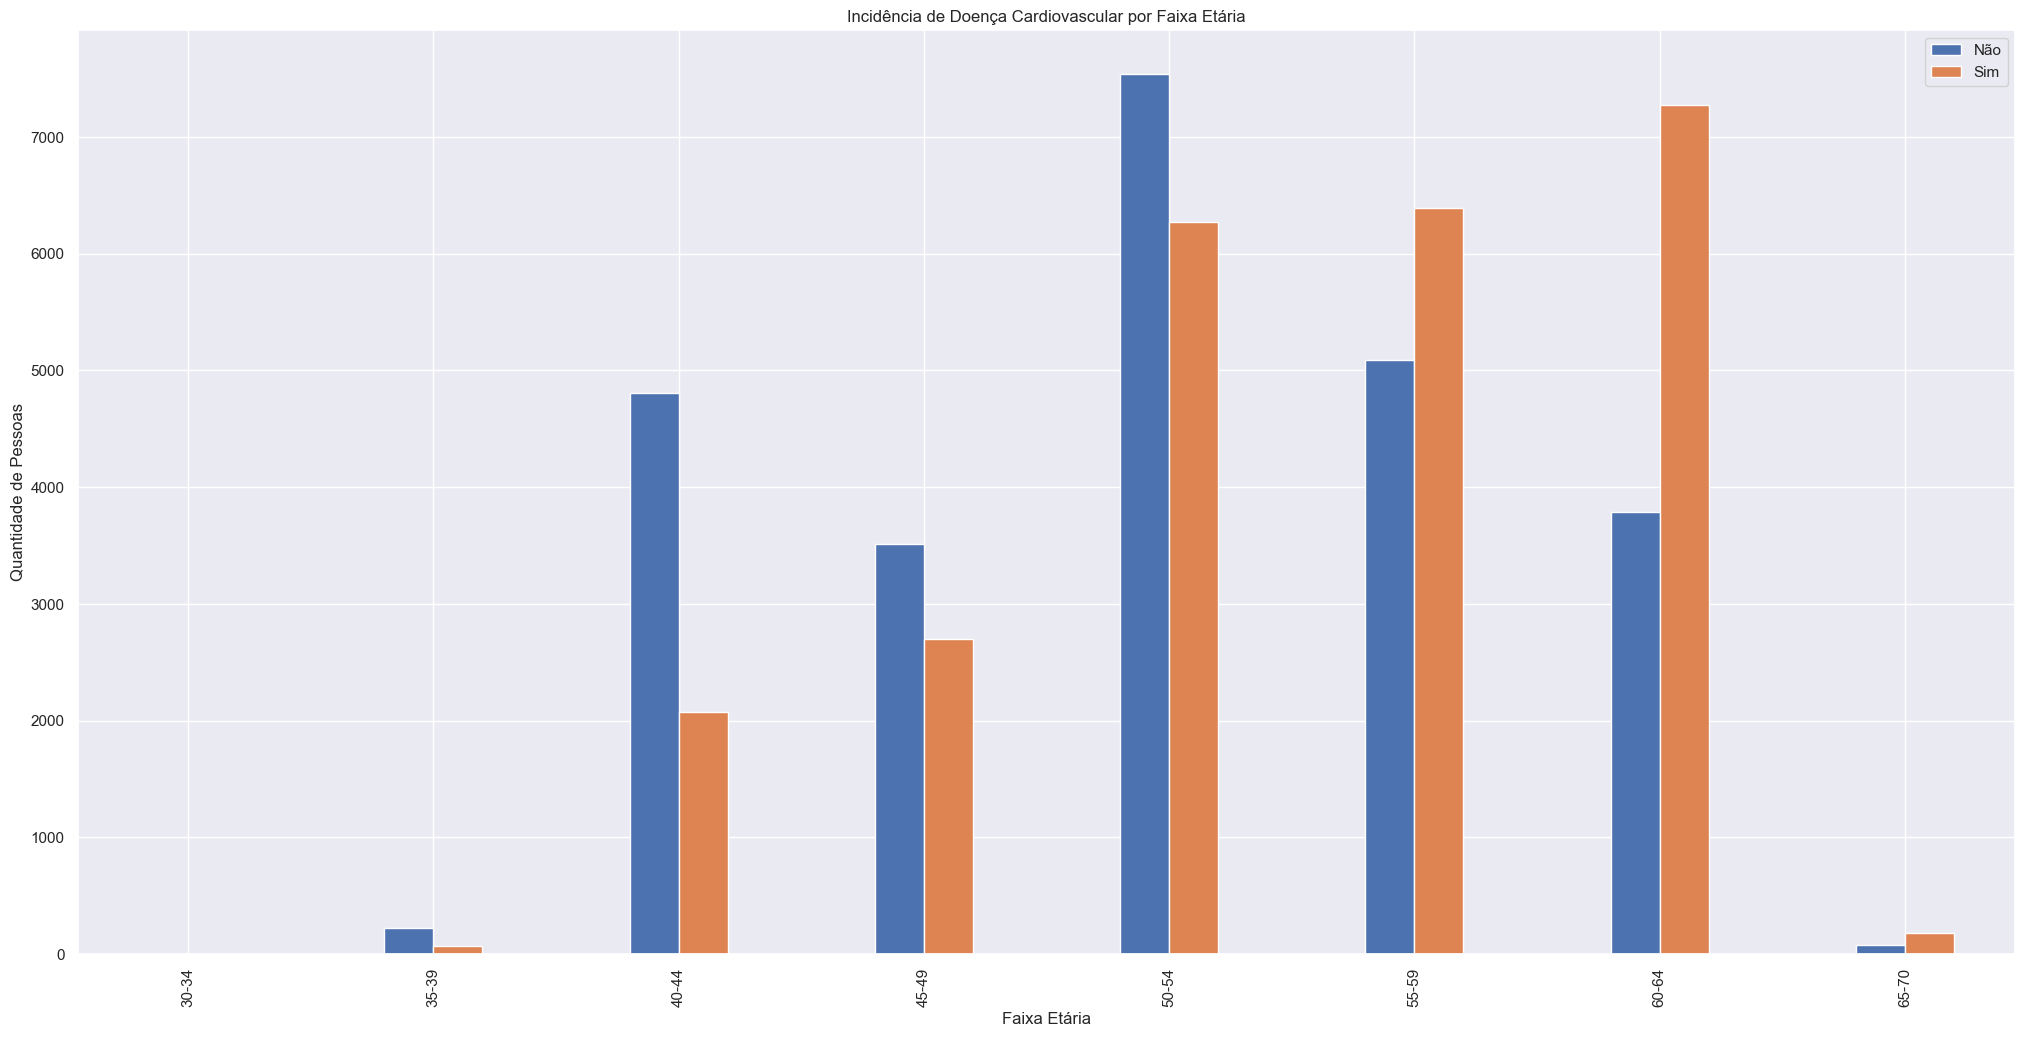

In [40]:
# Cópia Dataframe
df_421 = df4.copy()

# Definir os limites das faixas etárias
age_bins = [30, 35, 40, 45, 50, 55, 60, 65, np.inf]

# Definir os rótulos das faixas etárias
age_labels = ['30-34', '35-39', '40-44', '45-49', '50-54', '55-59', '60-64', '65-70']

# Adicionar uma nova coluna com as faixas etárias correspondentes
df_421['age_group'] = pd.cut(df_421['age_year'], bins=age_bins, labels=age_labels, right=False)

# Contar a quantidade de pessoas com doença cardiovascular em cada faixa etária
cardio_counts = df_421.groupby('age_group')['cardio'].value_counts().unstack().fillna(0)

# Reordenar as faixas etárias
cardio_counts = cardio_counts.reindex(age_labels)

# Plotar o gráfico de barras
cardio_counts.plot(kind='bar', width=0.4)
plt.xlabel('Faixa Etária')
plt.ylabel('Quantidade de Pessoas')
plt.title('Incidência de Doença Cardiovascular por Faixa Etária')
plt.legend(['Não', 'Sim'])
plt.show()

### 4.2.2. [2] Pessoas com Obesidade apresentam maior incidência de Doença Cardio.

[VERDADEIRA] A maior concentração de incidência de doença cardio esta entre os grupos com IMC acima do normal.

In [41]:
# Verificando distribuição da Categoria obesity_class
df4['obesity_class'].unique()

array([ 0,  3,  1,  2, -1,  4], dtype=int64)

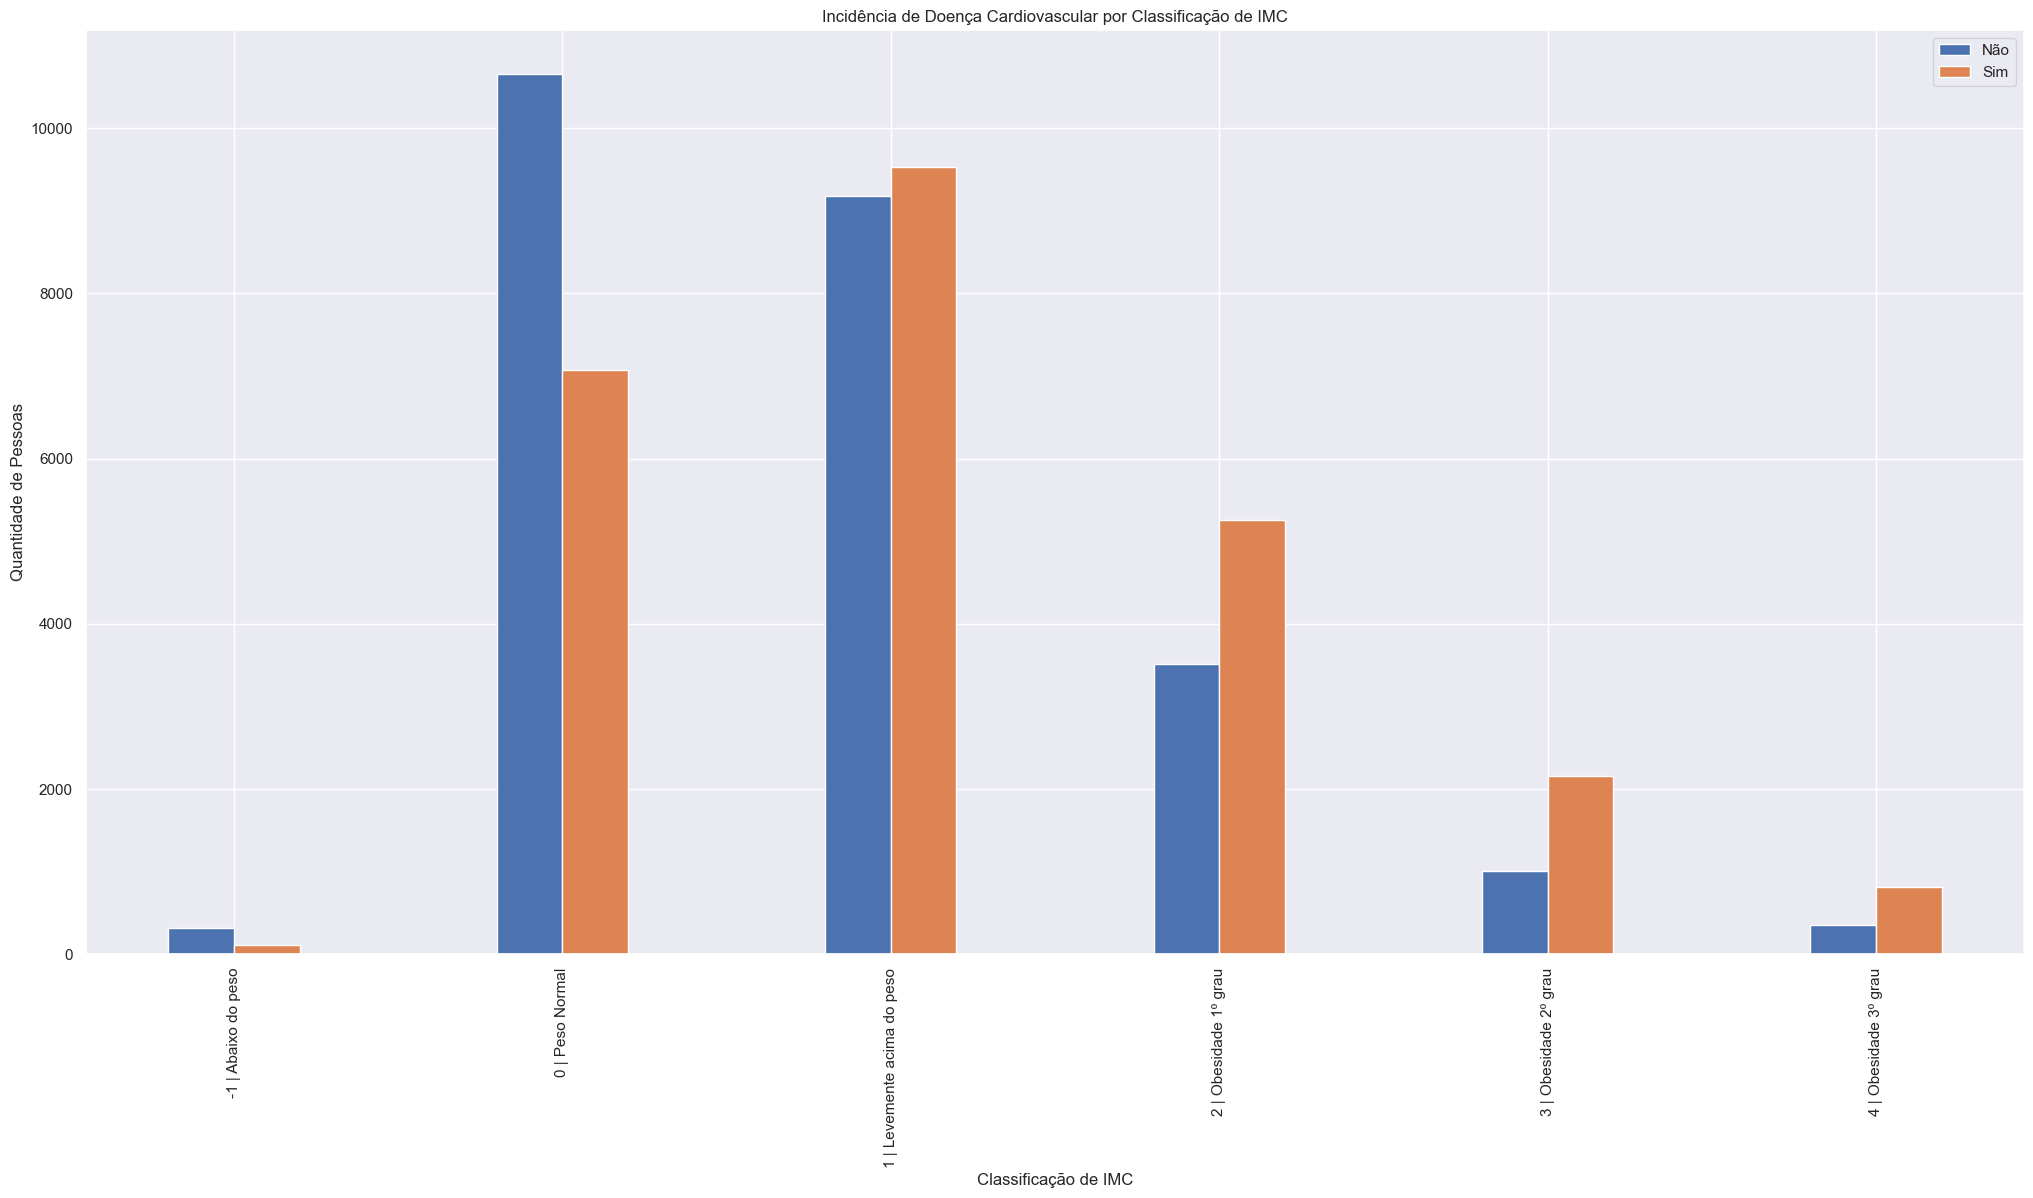

In [42]:
# Cópia Dataframe
df_422 = df4.copy()

# Contar a quantidade de pessoas com doença cardiovascular em cada classificação de IMC
cardio_counts = df_422.groupby('obesity_class')['cardio'].value_counts().unstack().fillna(0)

# Definir as descrições das classificações de IMC
obesity_labels = {
    -1: 'Abaixo do peso',
    0: 'Peso Normal',
    1: 'Levemente acima do peso',
    2: 'Obesidade 1º grau',
    3: 'Obesidade 2º grau',
    4: 'Obesidade 3º grau'
}

# Concatenar o rótulo com a descrição da classificação de IMC
cardio_counts['IMC Class'] = cardio_counts.index.map(lambda x: f'{x} | {obesity_labels[x]}')

# Reordenar as linhas pelo rótulo concatenado
cardio_counts = cardio_counts.set_index('IMC Class')

# Plotar o gráfico de barras
cardio_counts.plot(kind='bar', width=0.4)
plt.xlabel('Classificação de IMC')
plt.ylabel('Quantidade de Pessoas')
plt.title('Incidência de Doença Cardiovascular por Classificação de IMC')
plt.legend(['Não', 'Sim'])
plt.show()

### 4.2.3. [3] Pessoas com Pressão Sistólica e Diastólica > que o "normal" apresentam maior incidência de Doença Cardio.

[VERDADEIRA] No grupo de pessoas com pressão arterial acima do normal a incidência de doença cardio é maior.

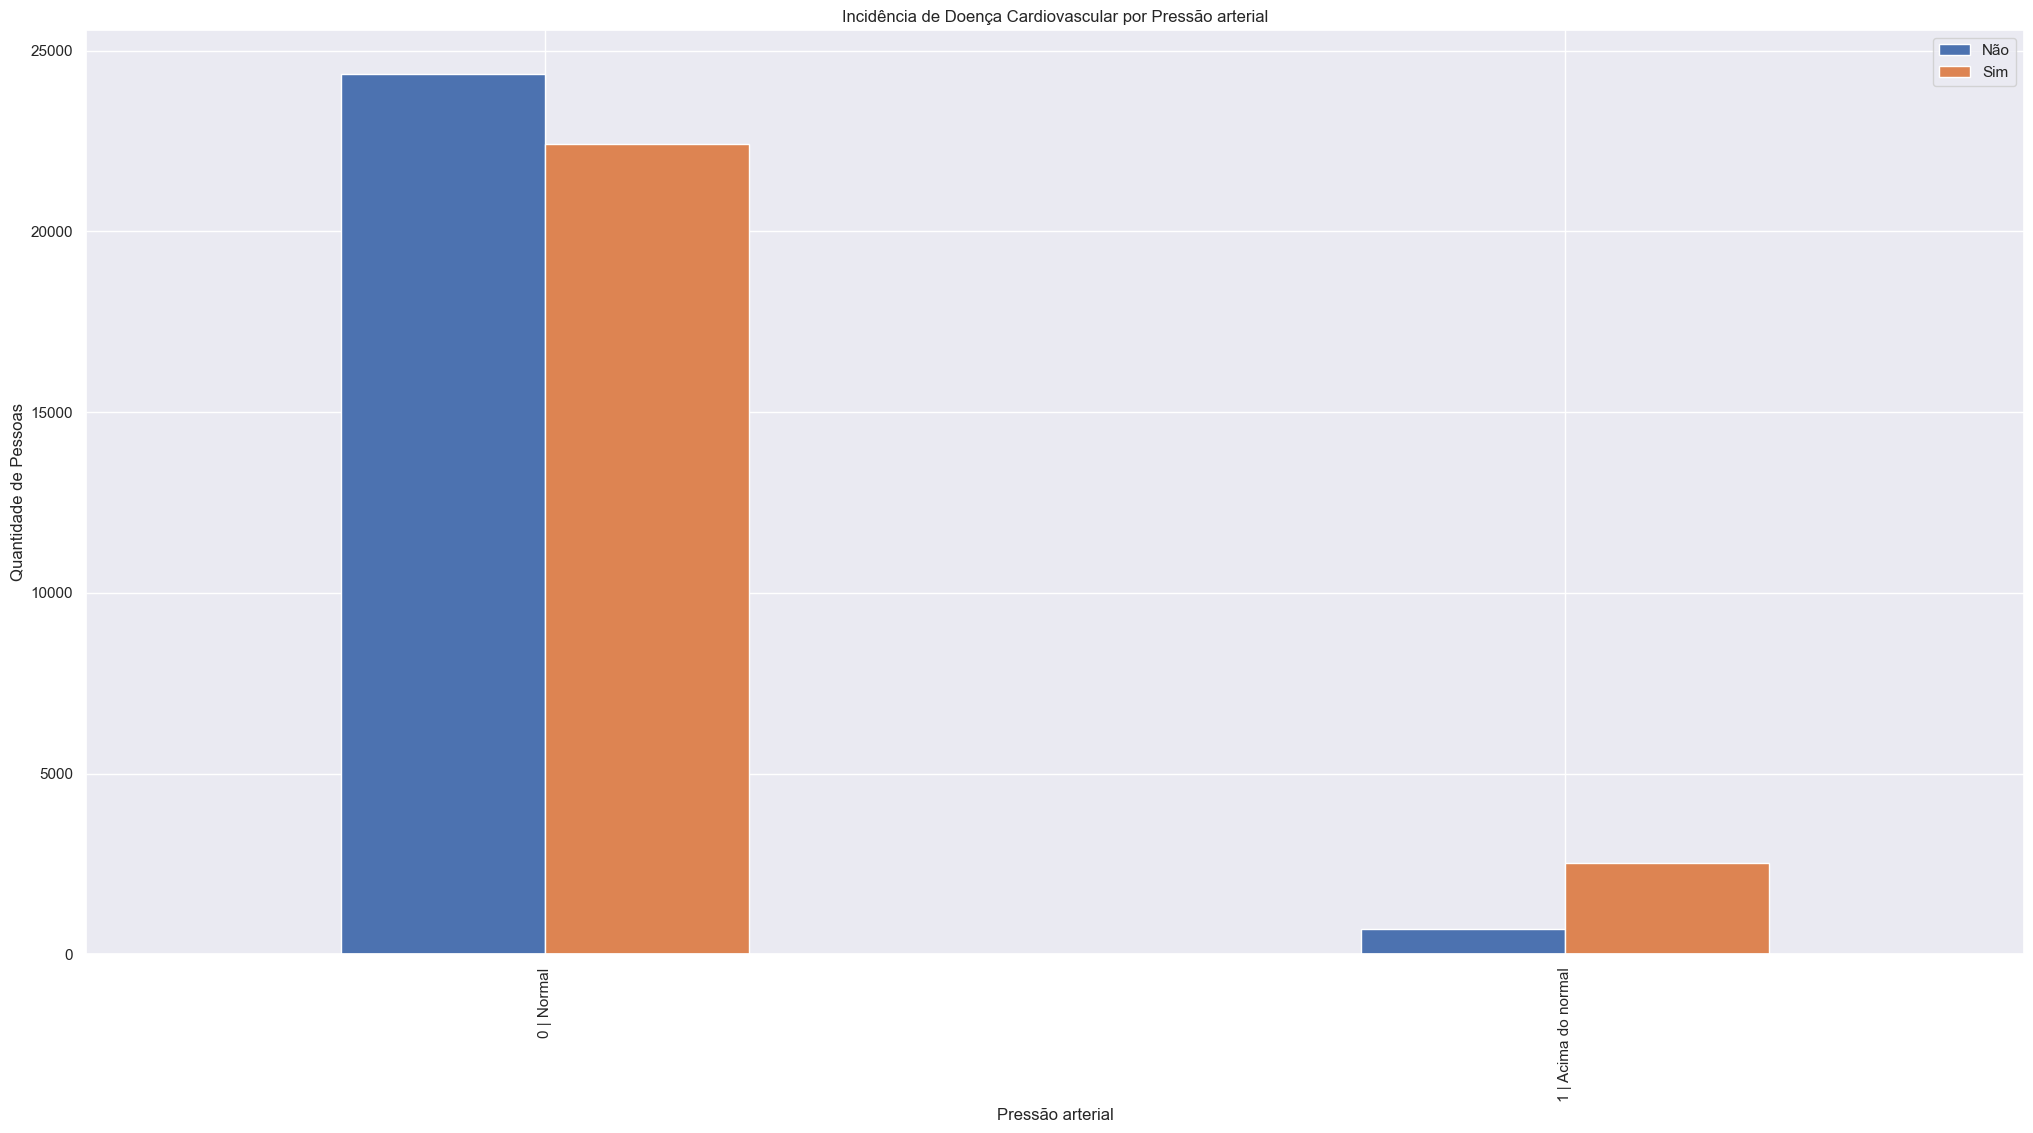

In [43]:
# Cópia Dataframe
df_423 = df4.copy()

# Contar a quantidade de pessoas com doença cardiovascular x Pressão Arterial
cardio_counts = df_423.groupby('pressure_class')['cardio'].value_counts().unstack().fillna(0)

# Definir a descrição da pressão arterial
pressure_labels = {0: 'Normal', 1: 'Acima do normal'}

# Concatenar o rótulo com a descrição da pressaão arterial
cardio_counts['Pressure Class'] = cardio_counts.index.map(lambda x: f'{x} | {pressure_labels[x]}')

# Reordenar as por Pressão arterial
cardio_counts = cardio_counts.set_index('Pressure Class')

# Plotar o gráfico de barras
cardio_counts.plot(kind='bar', width=0.4)
plt.xlabel('Pressão arterial')
plt.ylabel('Quantidade de Pessoas')
plt.title('Incidência de Doença Cardiovascular por Pressão arterial')
plt.legend(['Não', 'Sim'])
plt.show()

### 4.2.4. [4] Pessoas do Gênero Masculino apresentam Doença Cardio a mais que o Feminino.

[VERDADEIRA] Pessoas do gênero Masculino apresentam doença cardio em quantidades maiores do que o gênero Feminino.

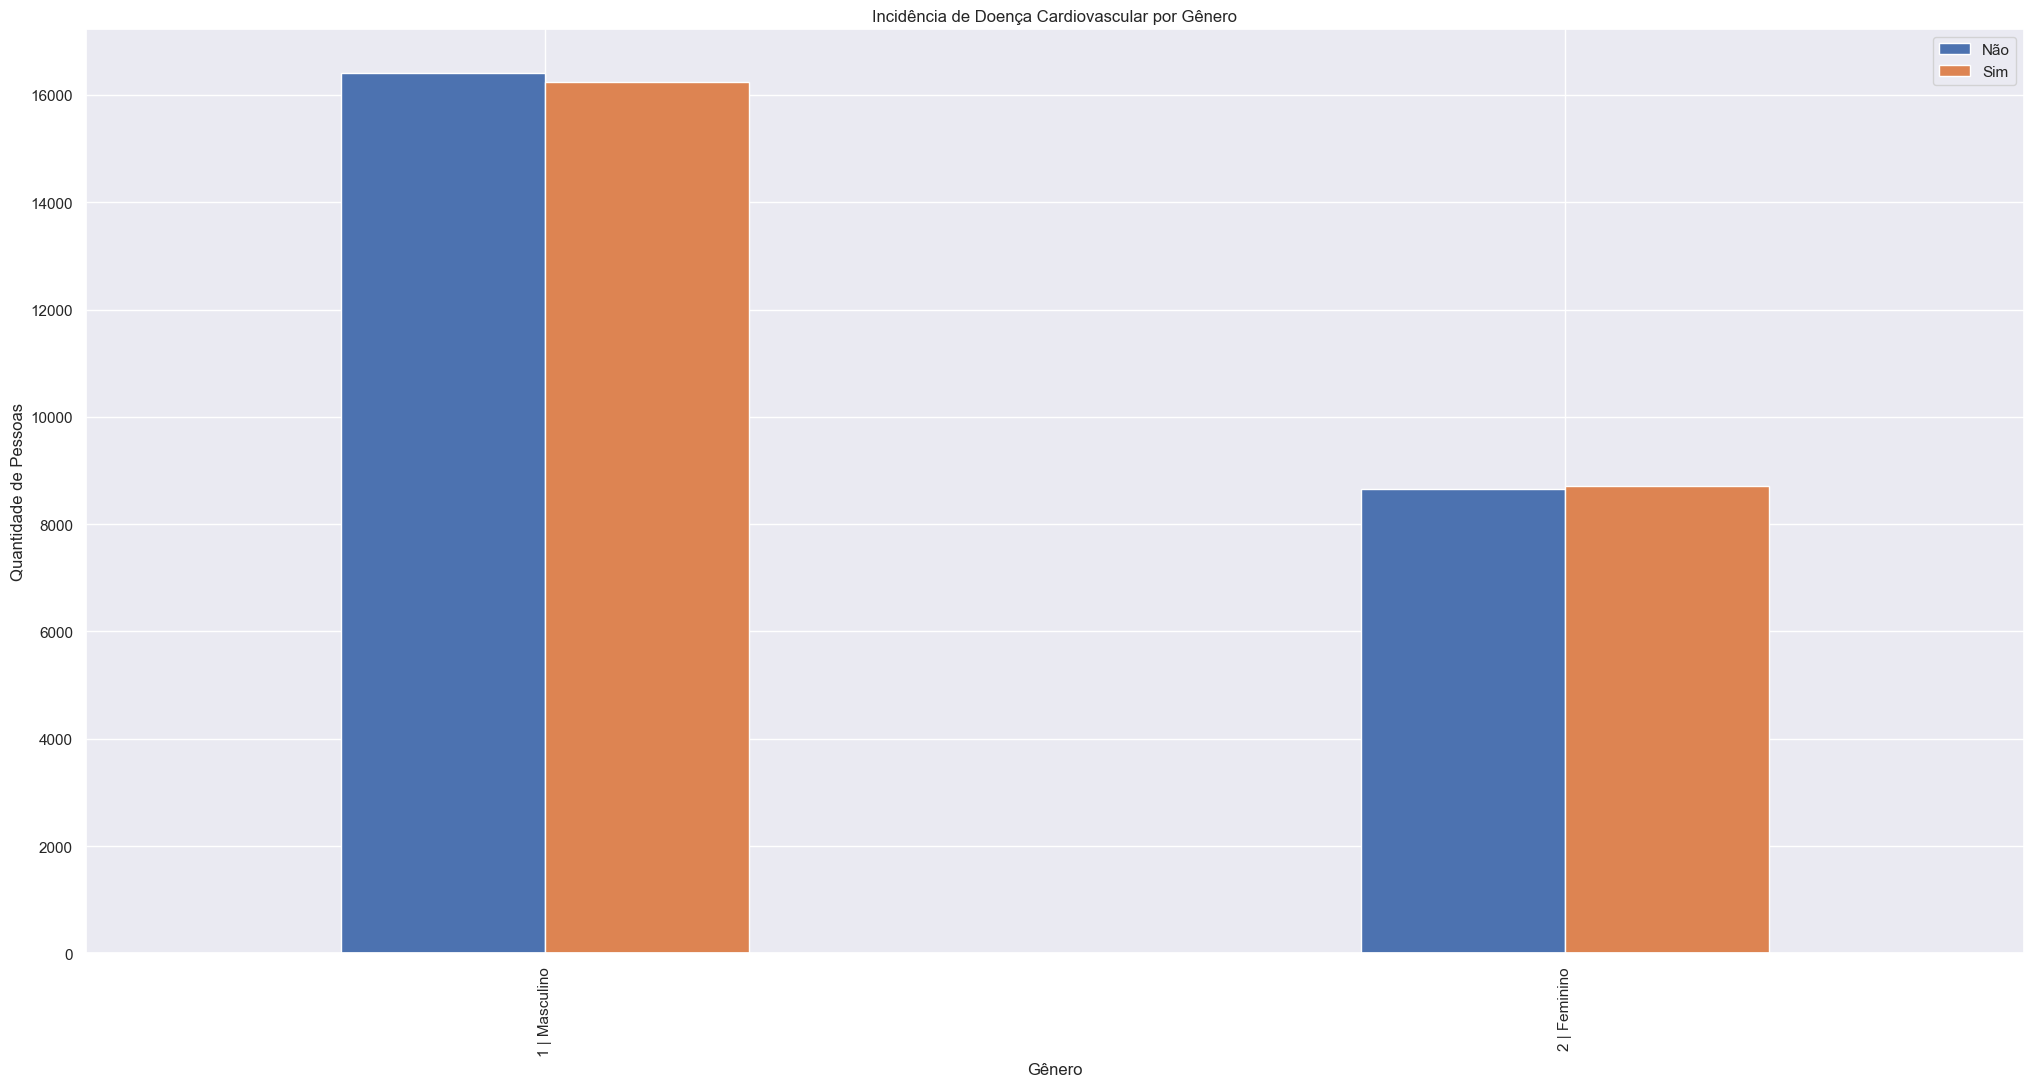

In [44]:
# Cópia Dataframe
df_424 = df4.copy()

# Contar a quantidade de pessoas com doença cardiovascular x Gênero
cardio_counts = df_424.groupby('gender')['cardio'].value_counts().unstack().fillna(0)

# Definir a descrição de gênero
gender_labels = {1: 'Masculino', 2: 'Feminino'}

# Concatenar o rótulo com a descrição de gênero
cardio_counts['Gender Class'] = cardio_counts.index.map(lambda x: f'{x} | {gender_labels[x]}')

# Reordenar as por gênero
cardio_counts = cardio_counts.set_index('Gender Class')

# Plotar o gráfico de barras
cardio_counts.plot(kind='bar', width=0.4)
plt.xlabel('Gênero')
plt.ylabel('Quantidade de Pessoas')
plt.title('Incidência de Doença Cardiovascular por Gênero')
plt.legend(['Não', 'Sim'])
plt.show()

### 4.2.5. [5] Colesterol Acima do Normal apresentam maior incidência de Doença Cardio.

[VERDADEIRA] Pessoas com nível de Colesterol elevado apresentam maior incidência de doença Cardio.

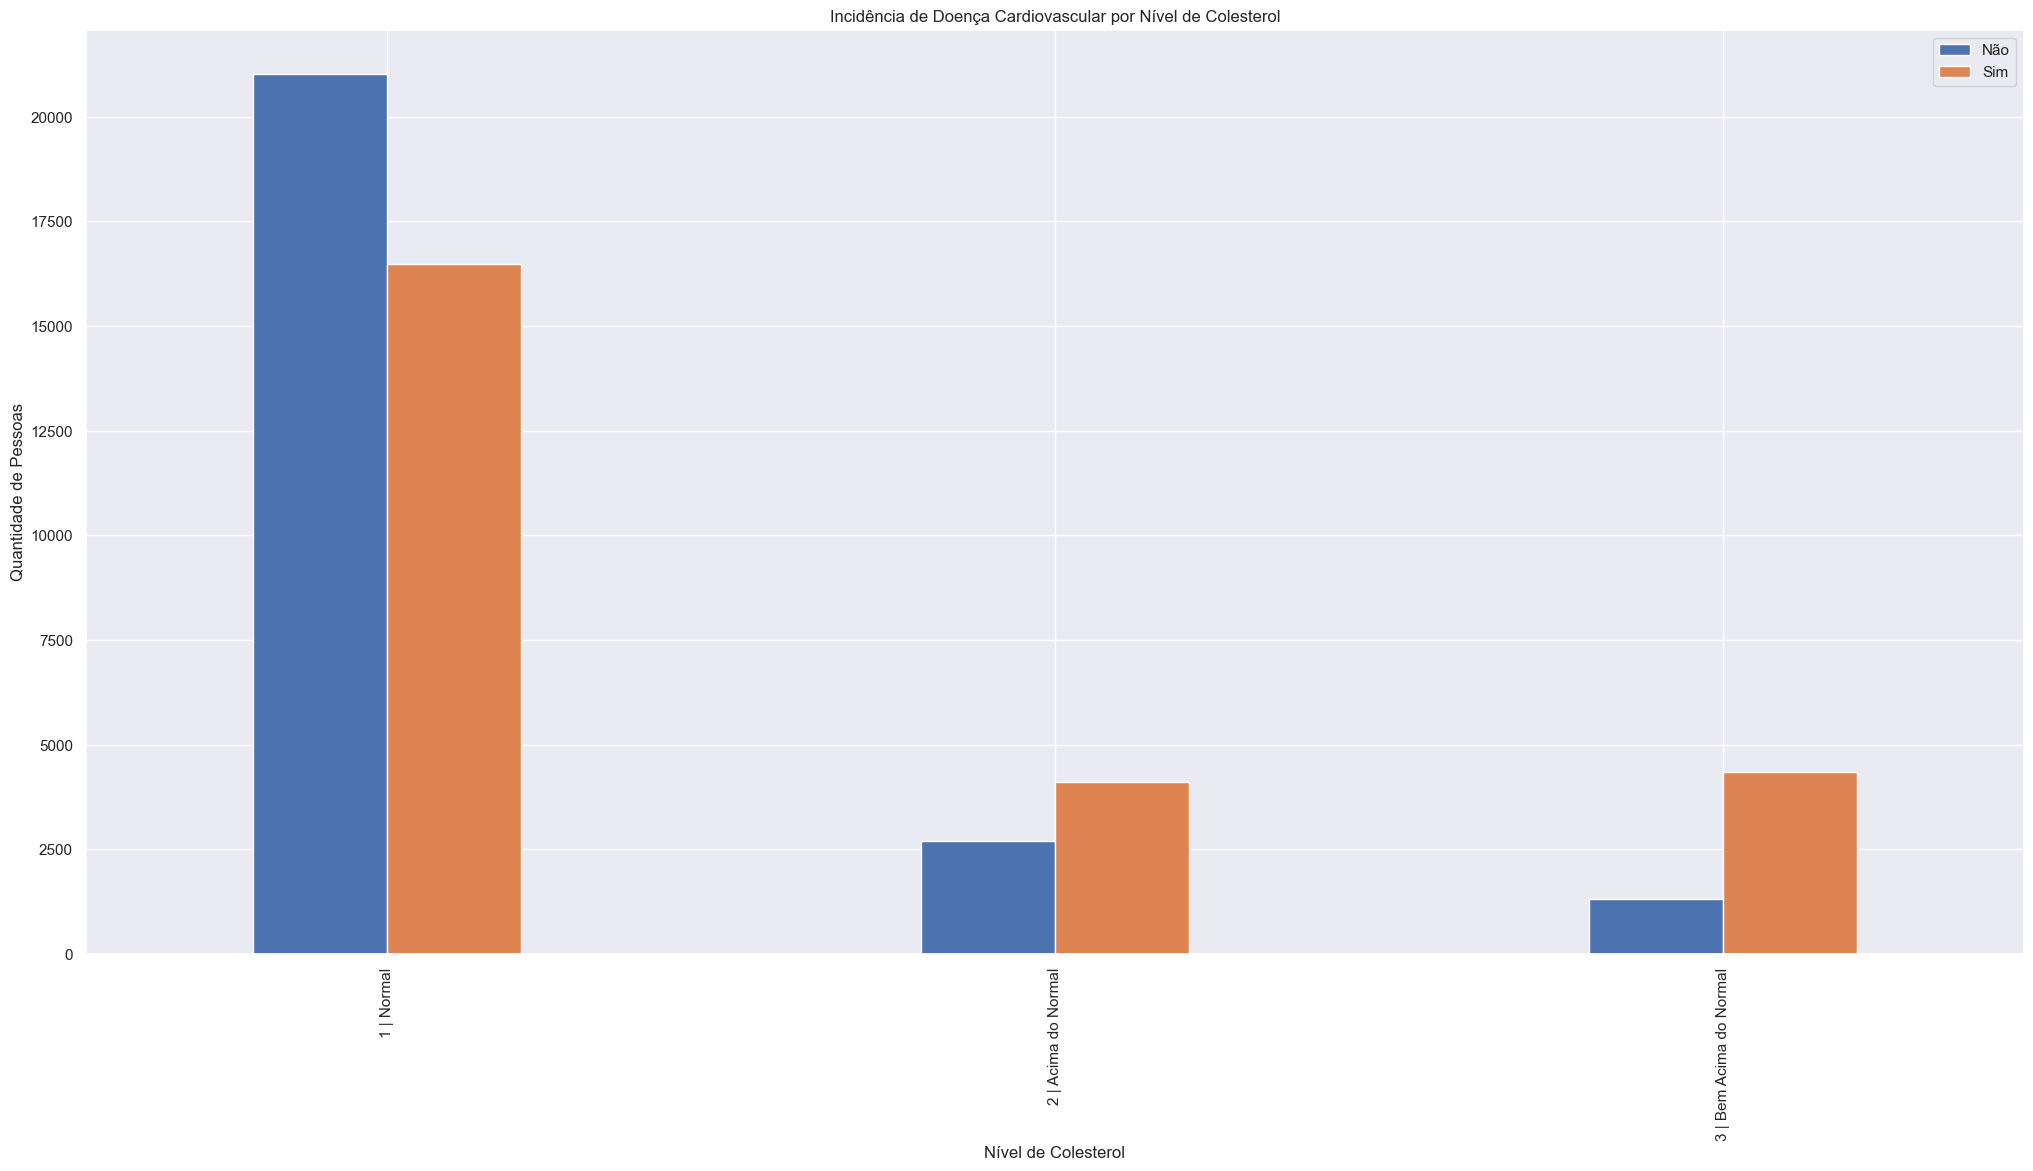

In [45]:
# Cópia Dataframe
df_425 = df4.copy()

# Contar a quantidade de pessoas com doença cardiovascular x Colesterol
cardio_counts = df_425.groupby('cholesterol')['cardio'].value_counts().unstack().fillna(0)

# Definir a descrição de colesterol
cholesterol_labels = {1: 'Normal', 2: 'Acima do Normal', 3: 'Bem Acima do Normal'}

# Concatenar o rótulo com a descrição de colesterol
cardio_counts['Cholesterol Class'] = cardio_counts.index.map(lambda x: f'{x} | {cholesterol_labels[x]}')

# Reordenar as por colesterol
cardio_counts = cardio_counts.set_index('Cholesterol Class')

# Plotar o gráfico de barras
cardio_counts.plot(kind='bar', width=0.4)
plt.xlabel('Nível de Colesterol')
plt.ylabel('Quantidade de Pessoas')
plt.title('Incidência de Doença Cardiovascular por Nível de Colesterol')
plt.legend(['Não', 'Sim'])
plt.show()

### 4.2.6. [6] Glicose Acima do Normal apresentam maior incidência de Doença Cardio.

[VERDADEIRA] Pessoas com nível de Glicose elevado apresentam maior incidência de doença Cardio.

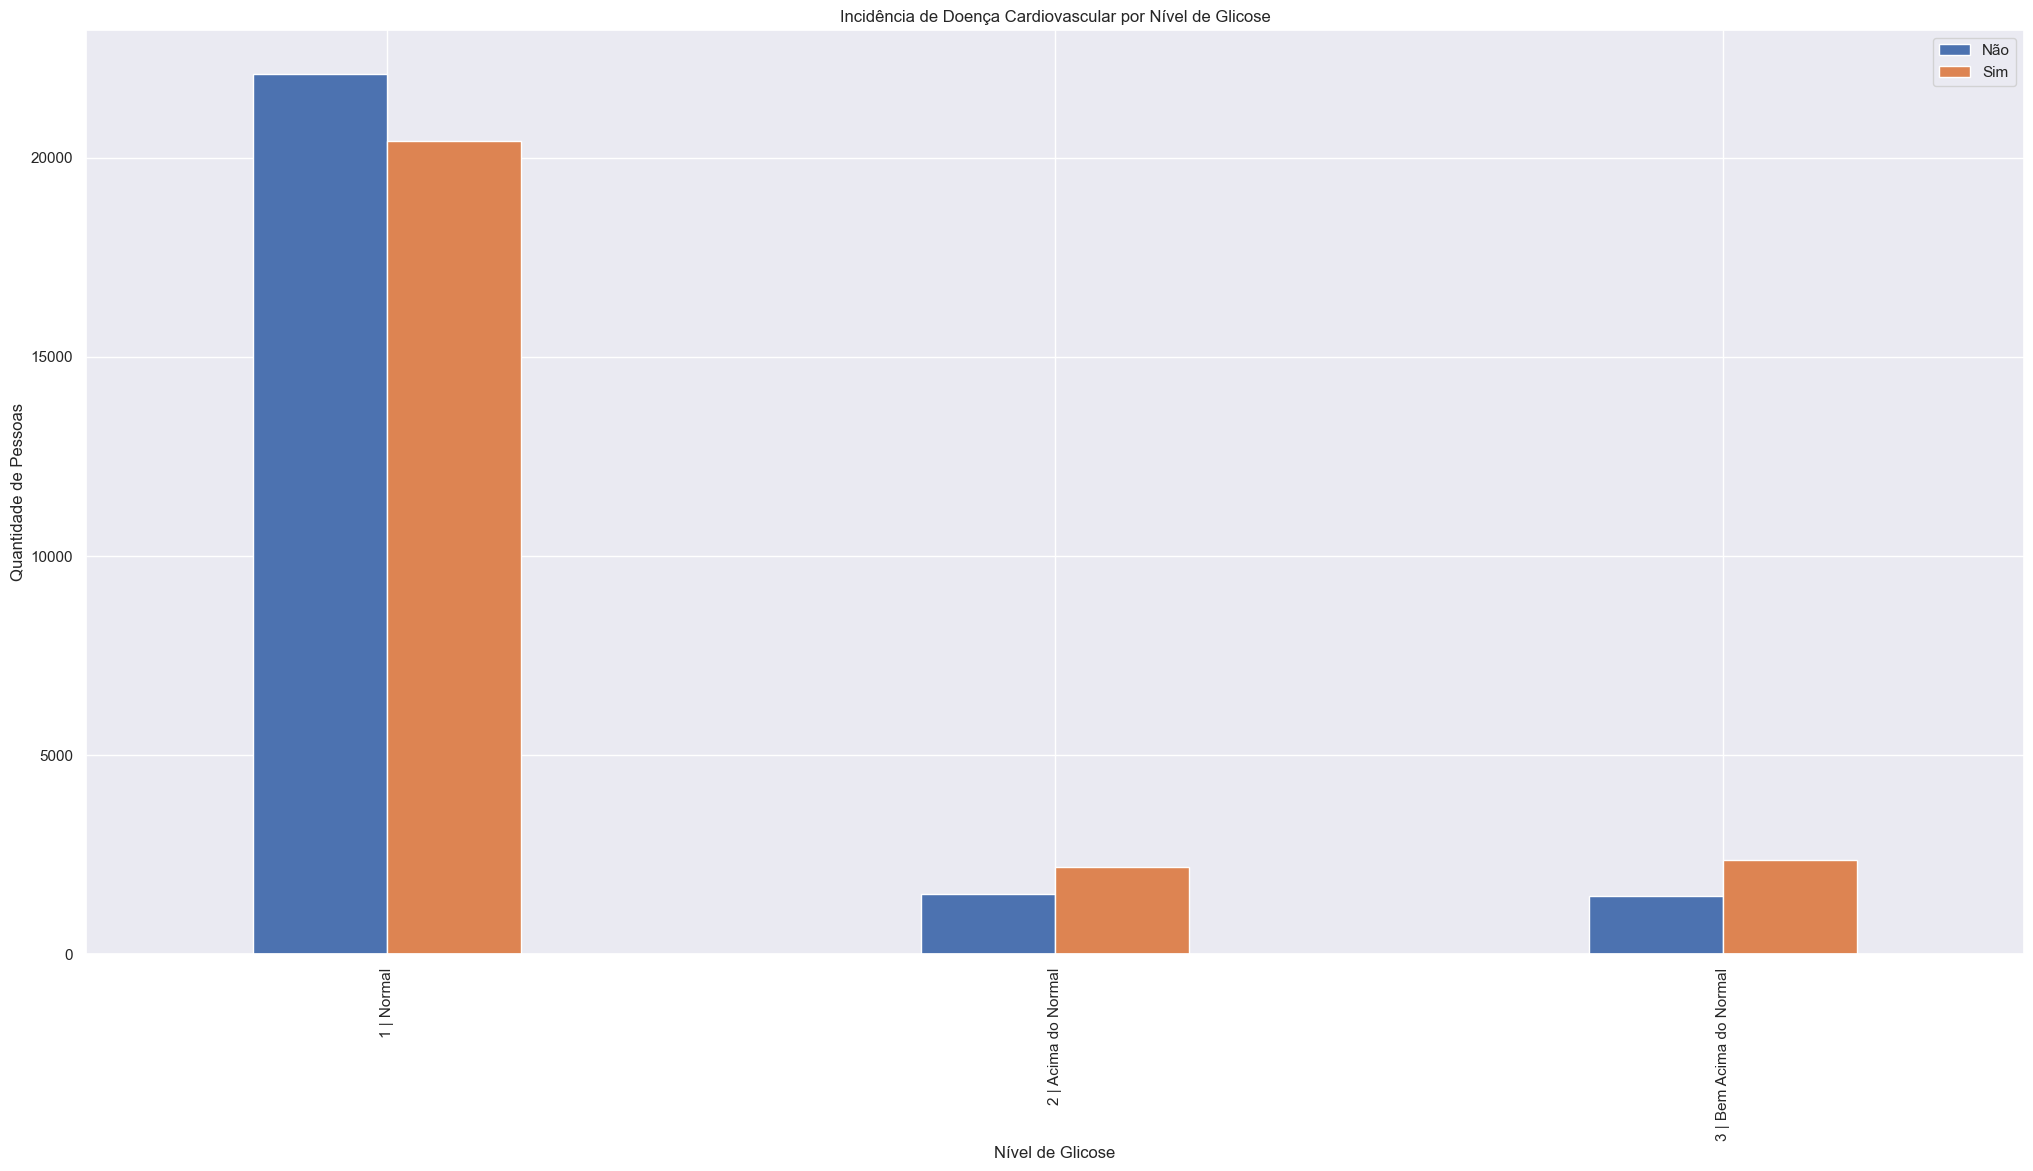

In [46]:
# Cópia Dataframe
df_426 = df4.copy()

# Contar a quantidade de pessoas com doença cardiovascular x Glicose
cardio_counts = df_426.groupby('gluc')['cardio'].value_counts().unstack().fillna(0)

# Definir a descrição de colesterol
gluc_labels = {1: 'Normal', 2: 'Acima do Normal', 3: 'Bem Acima do Normal'}

# Concatenar o rótulo com a descrição de colesterol
cardio_counts['Gluc Class'] = cardio_counts.index.map(lambda x: f'{x} | {gluc_labels[x]}')

# Reordenar as por colesterol
cardio_counts = cardio_counts.set_index('Gluc Class')

# Plotar o gráfico de barras
cardio_counts.plot(kind='bar', width=0.4)
plt.xlabel('Nível de Glicose')
plt.ylabel('Quantidade de Pessoas')
plt.title('Incidência de Doença Cardiovascular por Nível de Glicose')
plt.legend(['Não', 'Sim'])
plt.show()

### 4.2.7. [7] Pessoas que praticam atividade física apresentam menor incidência de Doença Cardio.

[VERDADEIRA] Pessoas que praticam Atividade Física apresentam menor incidência de doença Cardio.

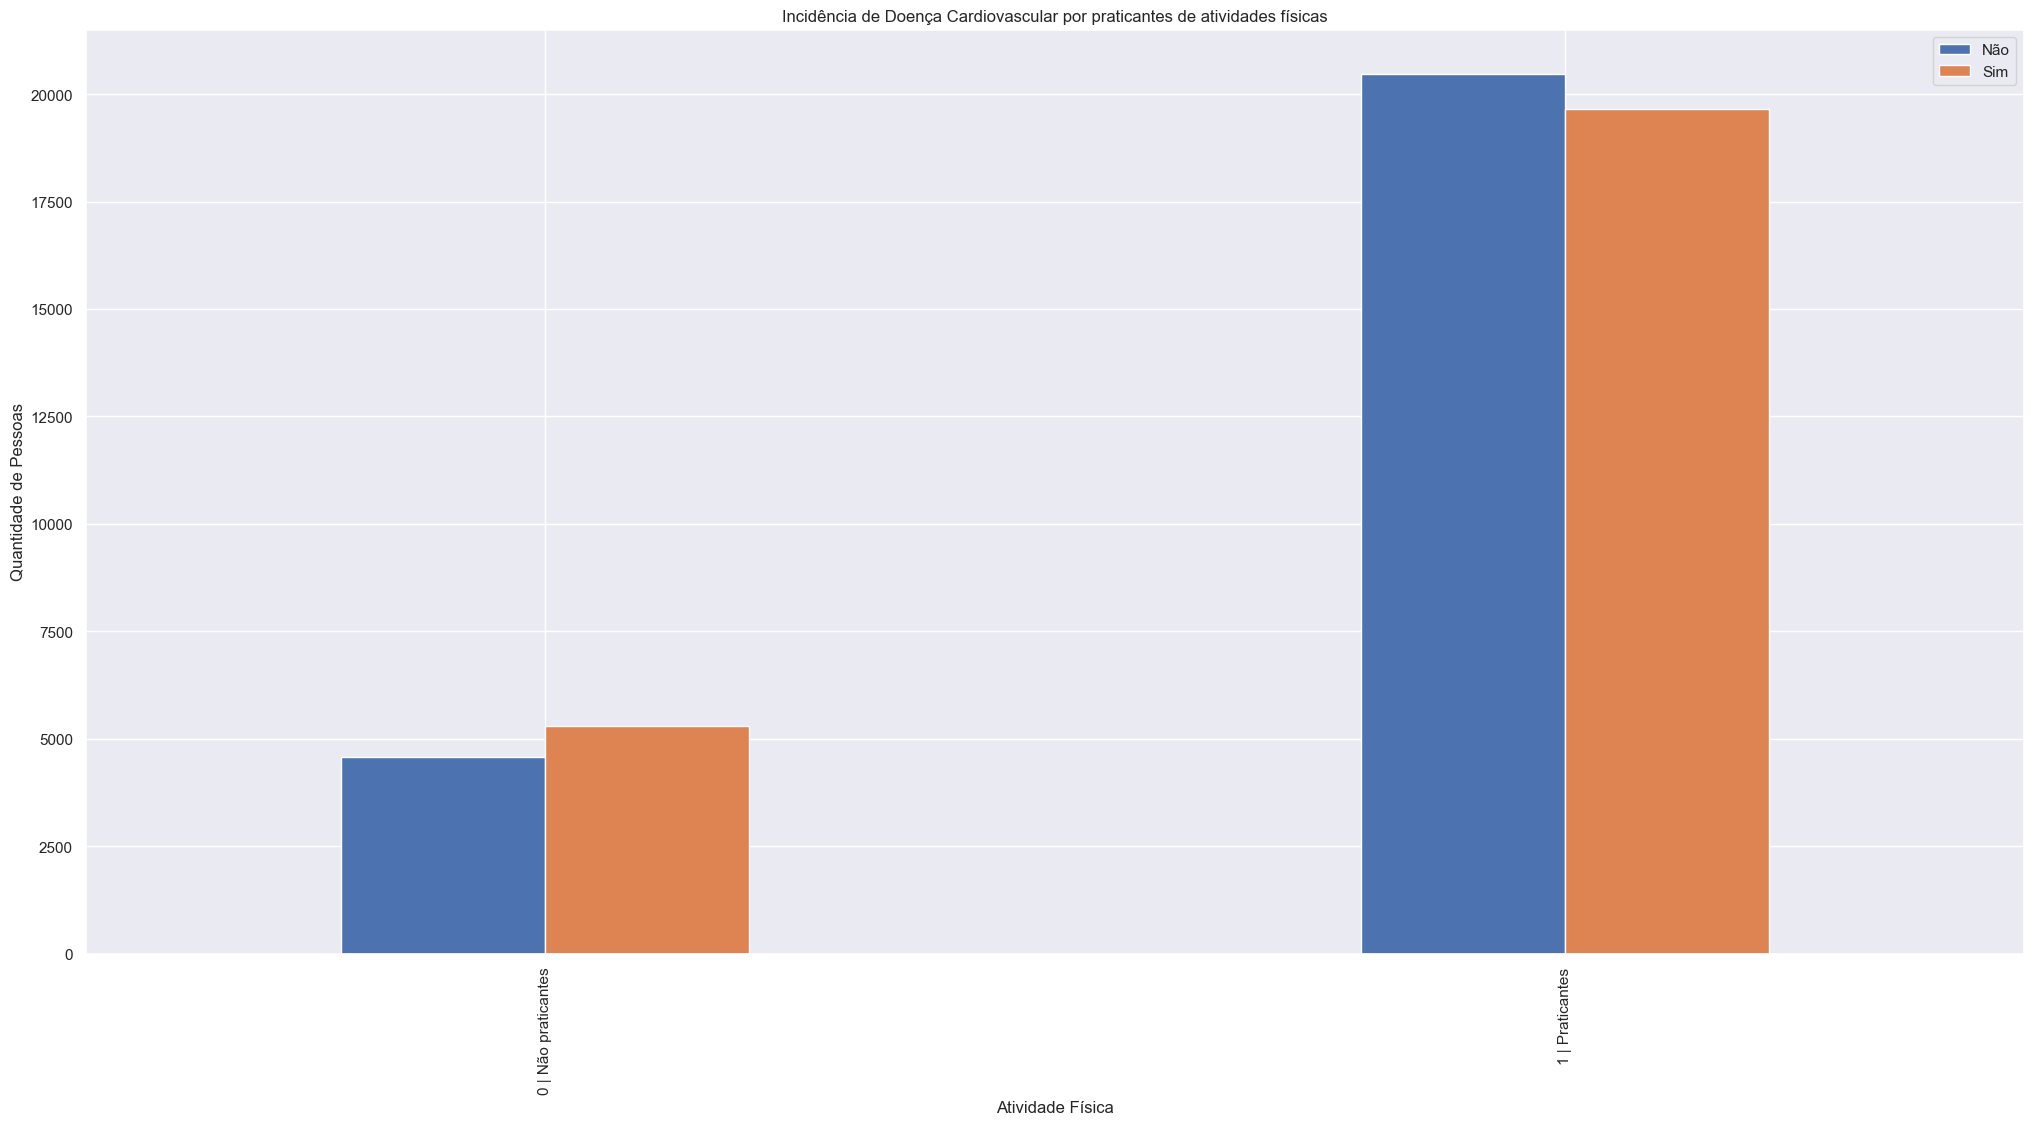

In [47]:
# Cópia Dataframe
df_427 = df4.copy()

# Contar a quantidade de pessoas com doença cardiovascular x Atividade Física
cardio_counts = df_427.groupby('active')['cardio'].value_counts().unstack().fillna(0)

# Definir a descrição de atividade física
active_labels = {0: 'Não praticantes', 1: 'Praticantes'}

# Concatenar o rótulo com a descrição de atividade física
cardio_counts['Active Class'] = cardio_counts.index.map(lambda x: f'{x} | {active_labels[x]}')

# Reordenar as por atividade física
cardio_counts = cardio_counts.set_index('Active Class')

# Plotar o gráfico de barras
cardio_counts.plot(kind='bar', width=0.4)
plt.xlabel('Atividade Física')
plt.ylabel('Quantidade de Pessoas')
plt.title('Incidência de Doença Cardiovascular por praticantes de atividades físicas')
plt.legend(['Não', 'Sim'])
plt.show()

### 4.2.8. [8] Pessoas que fumam apresentam maior incidência de Doença Cardio.

[FALSA] Pessoas fumantes na realidade apresentam menor incidência de doença Cardio.

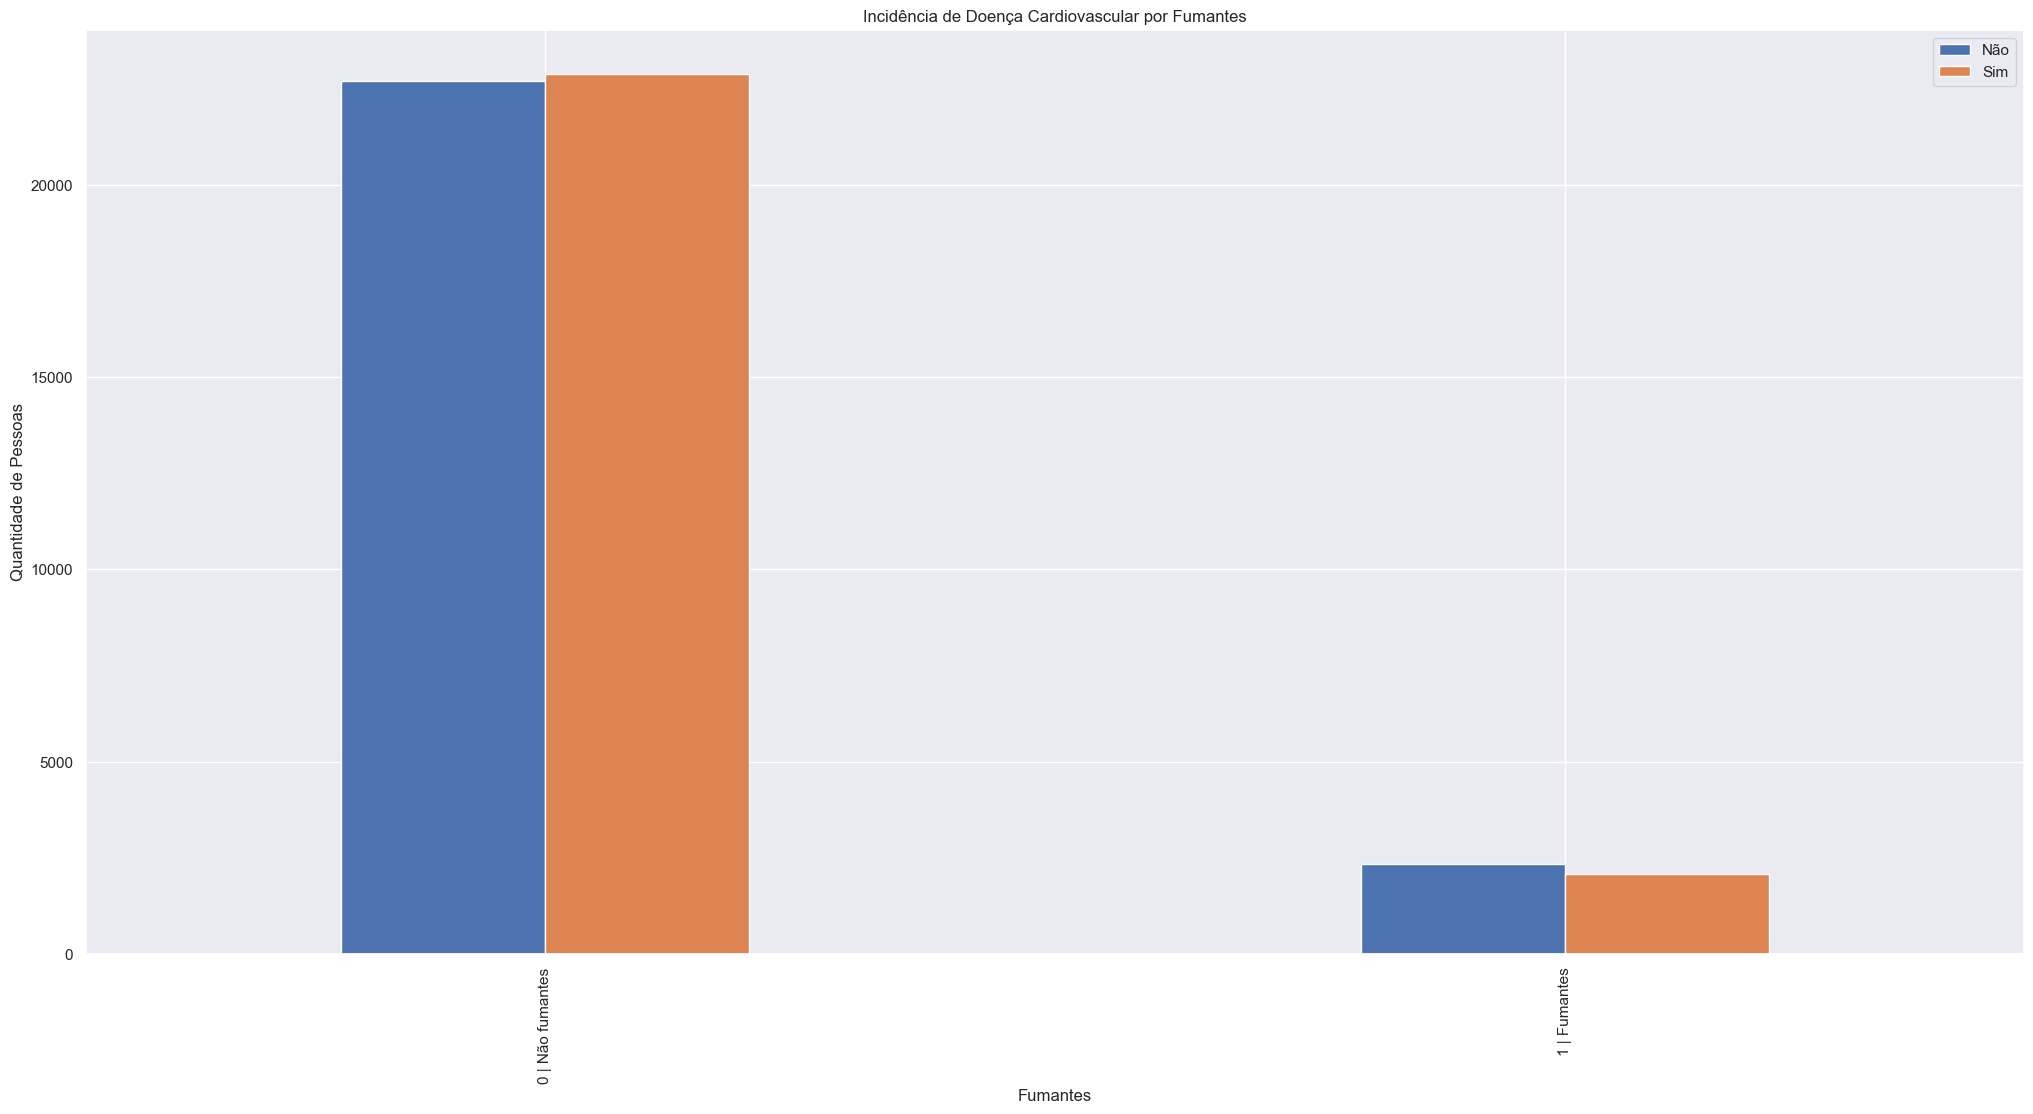

In [48]:
# Cópia Dataframe
df_428 = df4.copy()

# Contar a quantidade de pessoas com doença cardiovascular x Fumantes
cardio_counts = df_428.groupby('smoke')['cardio'].value_counts().unstack().fillna(0)

# Definir a descrição de fumantes
smoke_labels = {0: 'Não fumantes', 1: 'Fumantes'}

# Concatenar o rótulo com a descrição de fumantes
cardio_counts['Smoke Class'] = cardio_counts.index.map(lambda x: f'{x} | {smoke_labels[x]}')

# Reordenar as por fumantes
cardio_counts = cardio_counts.set_index('Smoke Class')

# Plotar o gráfico de barras
cardio_counts.plot(kind='bar', width=0.4)
plt.xlabel('Fumantes')
plt.ylabel('Quantidade de Pessoas')
plt.title('Incidência de Doença Cardiovascular por Fumantes')
plt.legend(['Não', 'Sim'])
plt.show()

### 4.2.9. [9] Pessoas que são alcoólatras apresentam maior incidência de Doença Cardio.

[FALSA] Não existe correlação direta, pois o comportamento de ingestão de alcool não afeta a incidência de doença Cardio.

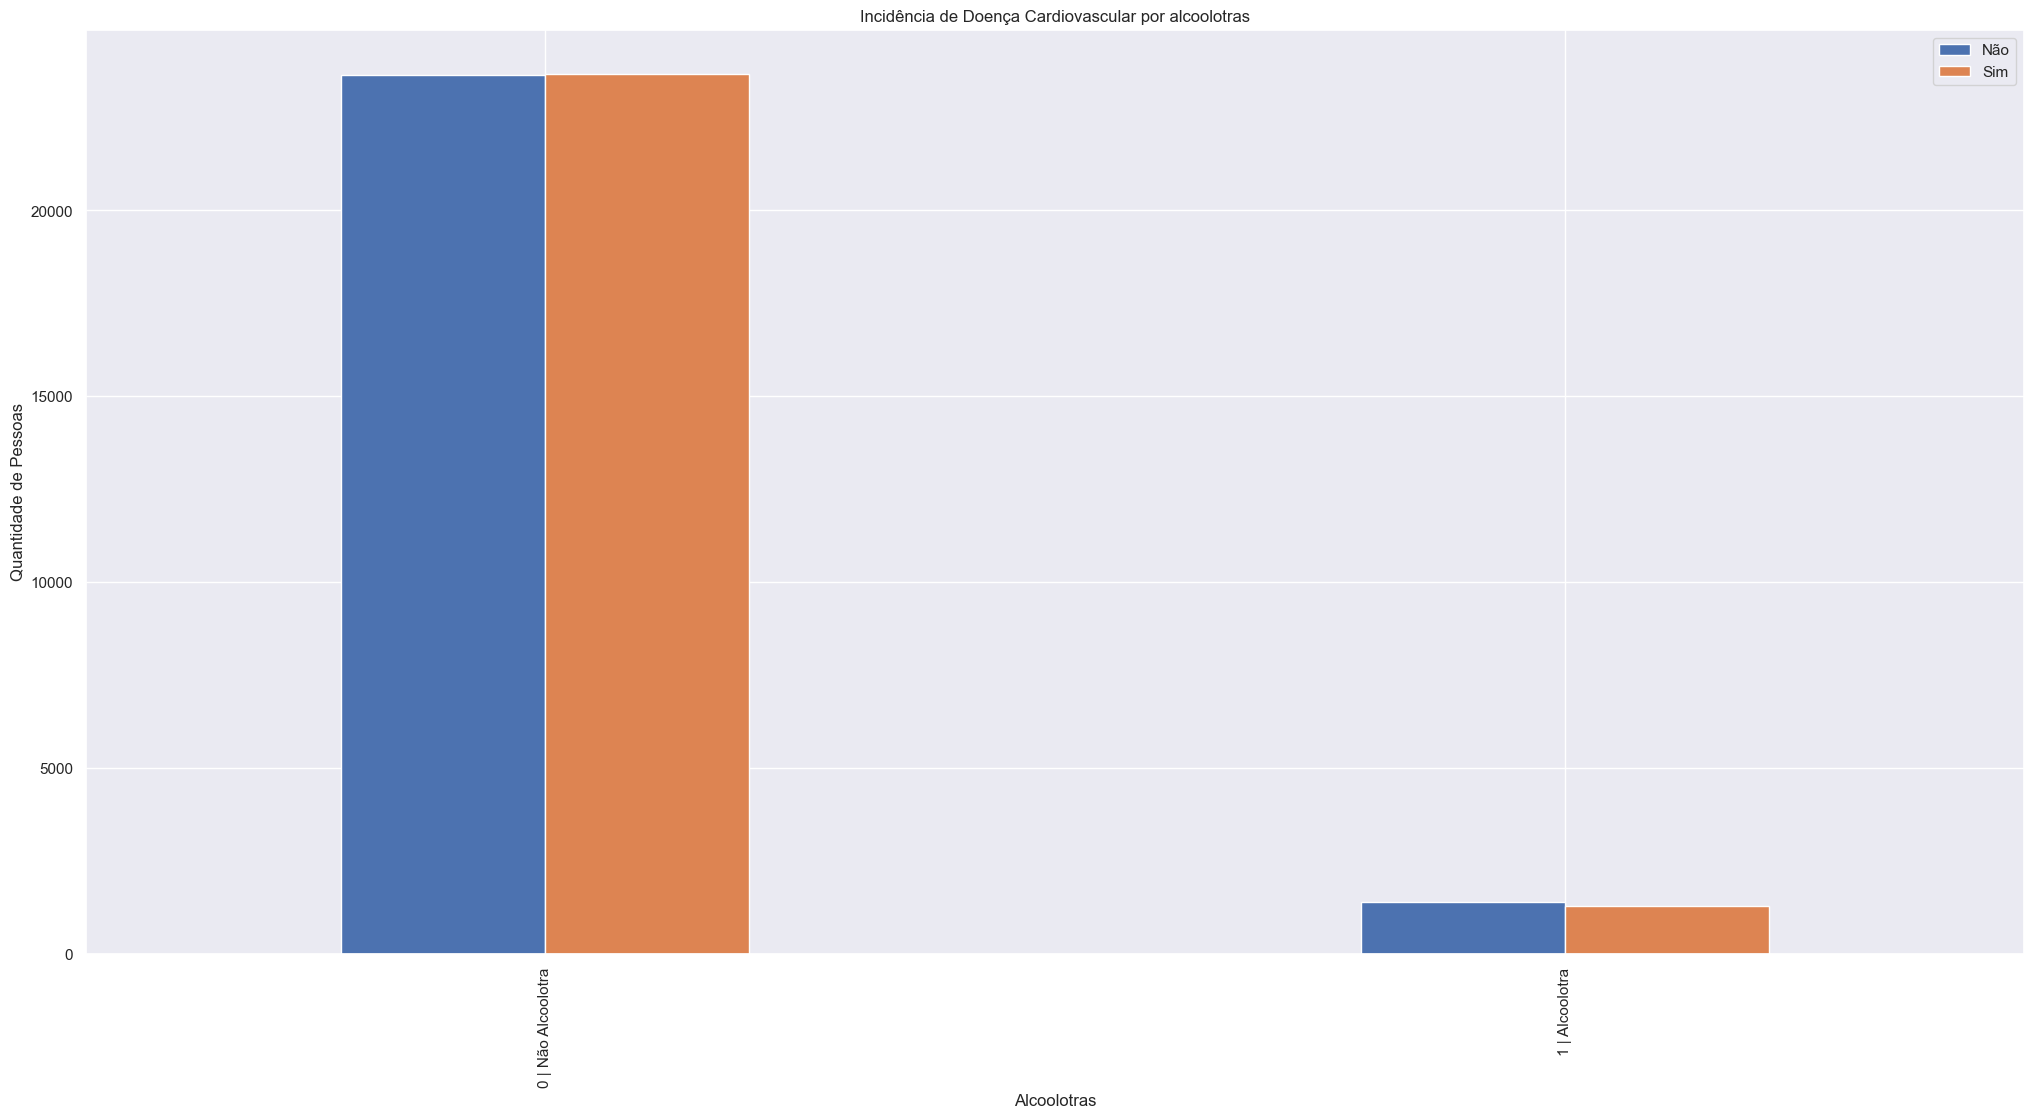

In [49]:
# Cópia Dataframe
df_429 = df4.copy()

# Contar a quantidade de pessoas com doença cardiovascular x Alcoolotras
cardio_counts = df_429.groupby('alco')['cardio'].value_counts().unstack().fillna(0)

# Definir a descrição de alcoolotras
alco_labels = {0: 'Não Alcoolotra', 1: 'Alcoolotra'}

# Concatenar o rótulo com a descrição de alcoolotras
cardio_counts['Alco Class'] = cardio_counts.index.map(lambda x: f'{x} | {alco_labels[x]}')

# Reordenar as por alcoolotras
cardio_counts = cardio_counts.set_index('Alco Class')

# Plotar o gráfico de barras
cardio_counts.plot(kind='bar', width=0.4)
plt.xlabel('Alcoolotras')
plt.ylabel('Quantidade de Pessoas')
plt.title('Incidência de Doença Cardiovascular por alcoolotras')
plt.legend(['Não', 'Sim'])
plt.show()

## 4.3. Multivariate Analysis

### 4.3.1. Numerical Attributes

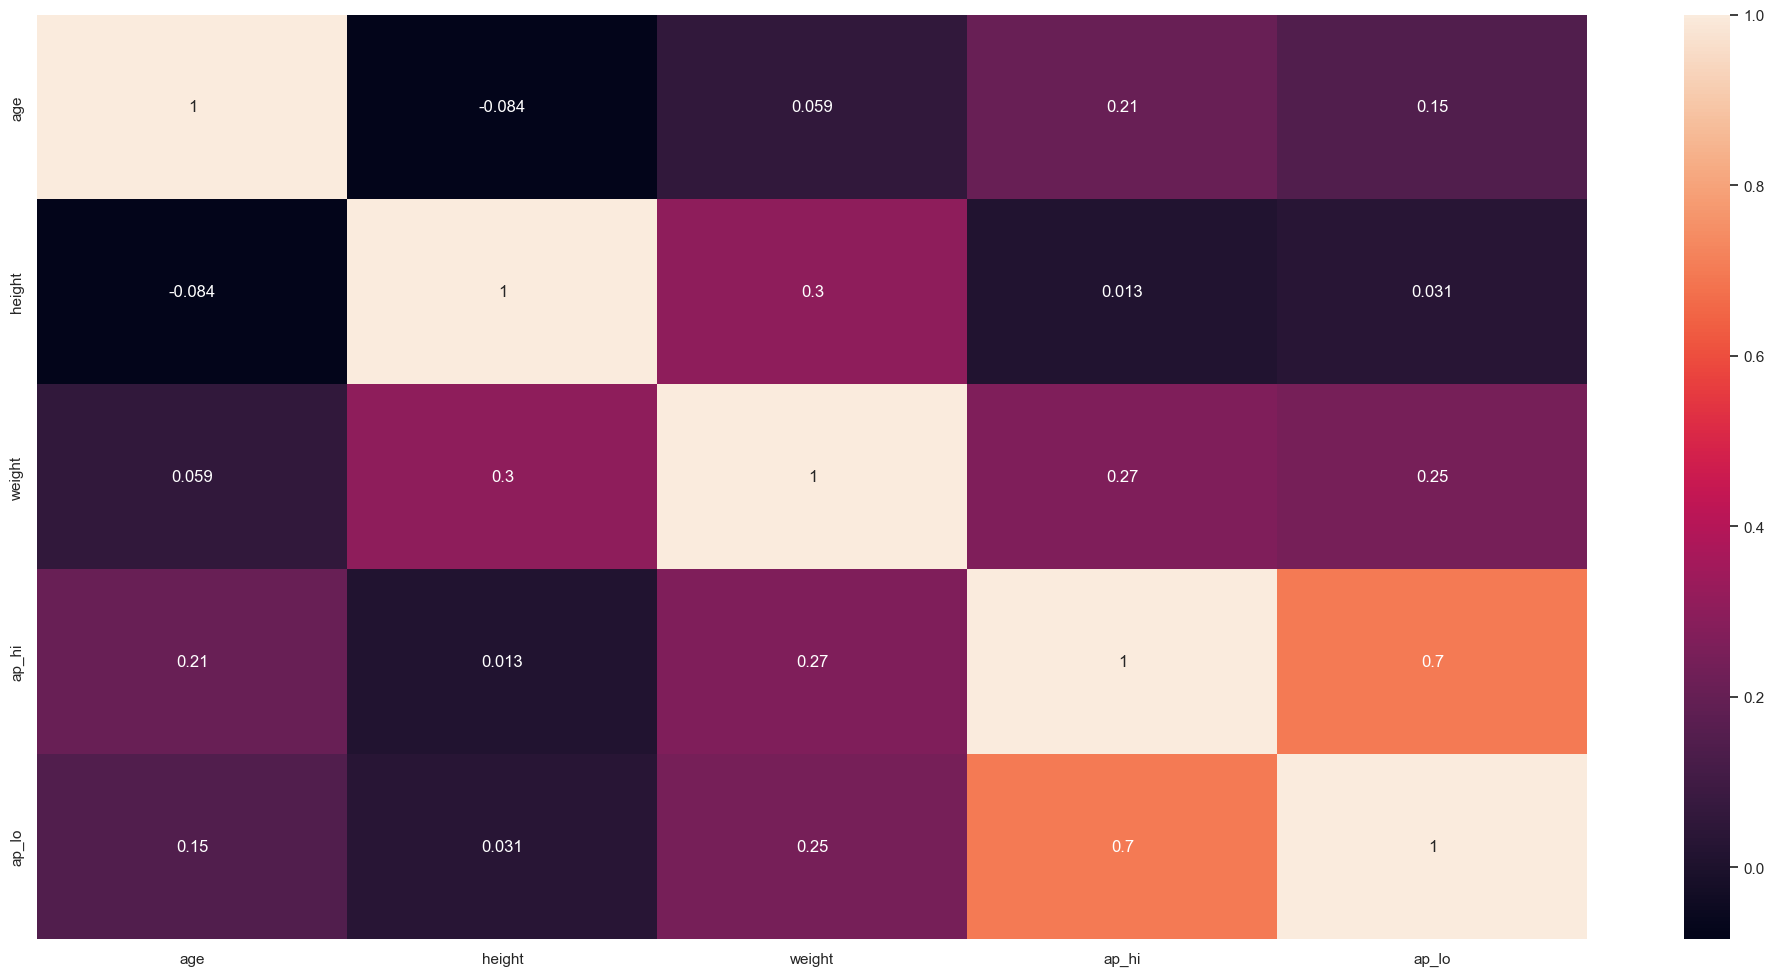

In [50]:
# Relação de Features e sua Relevância de Correlação (dataframe original)
correlation = num_attributes.corr( method='pearson' )
sns.heatmap( correlation, annot=True );

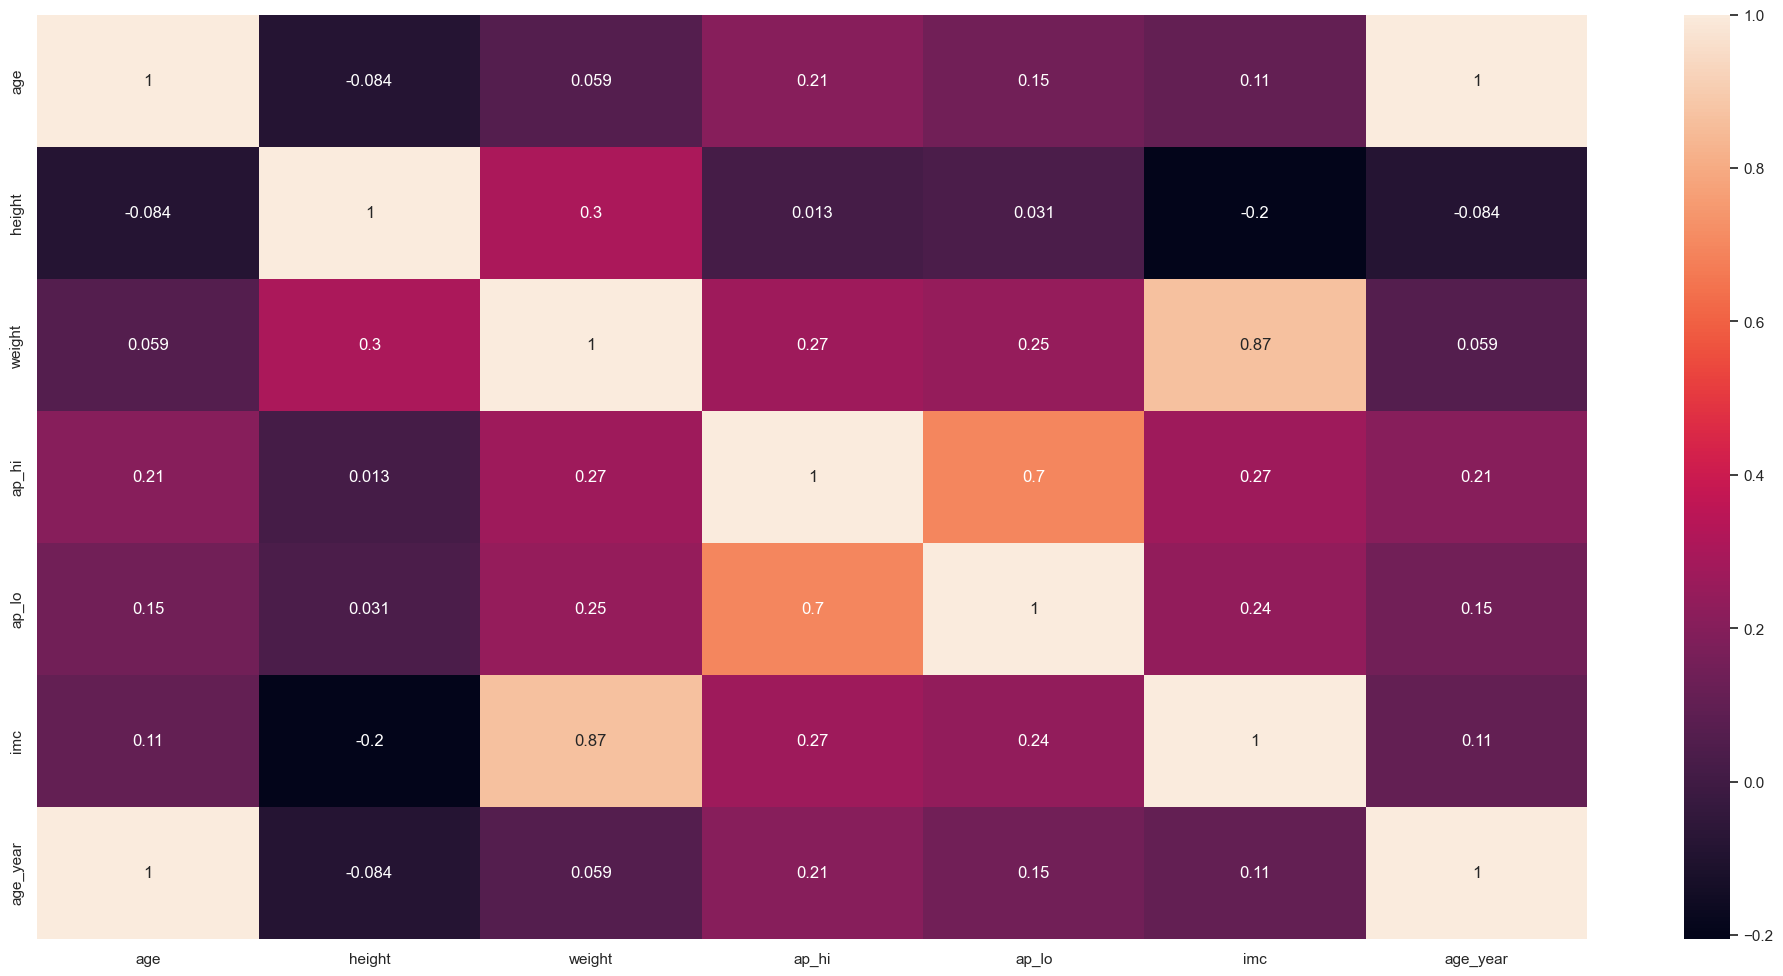

In [51]:
# Cópia Dataframe
df_431 = num_attributes.copy()

# Adicionando novas colunas criadas no Feature Engineering
df_431 = df_431.assign(imc=df4['imc'], age_year=df4['age_year'])

# Relação de Features e sua Relevância de Correlação (dataframe pós Feature Engineering)
correlation = df_431.corr( method='pearson' )
sns.heatmap( correlation, annot=True );

### 4.3.2. Categorical Attributes

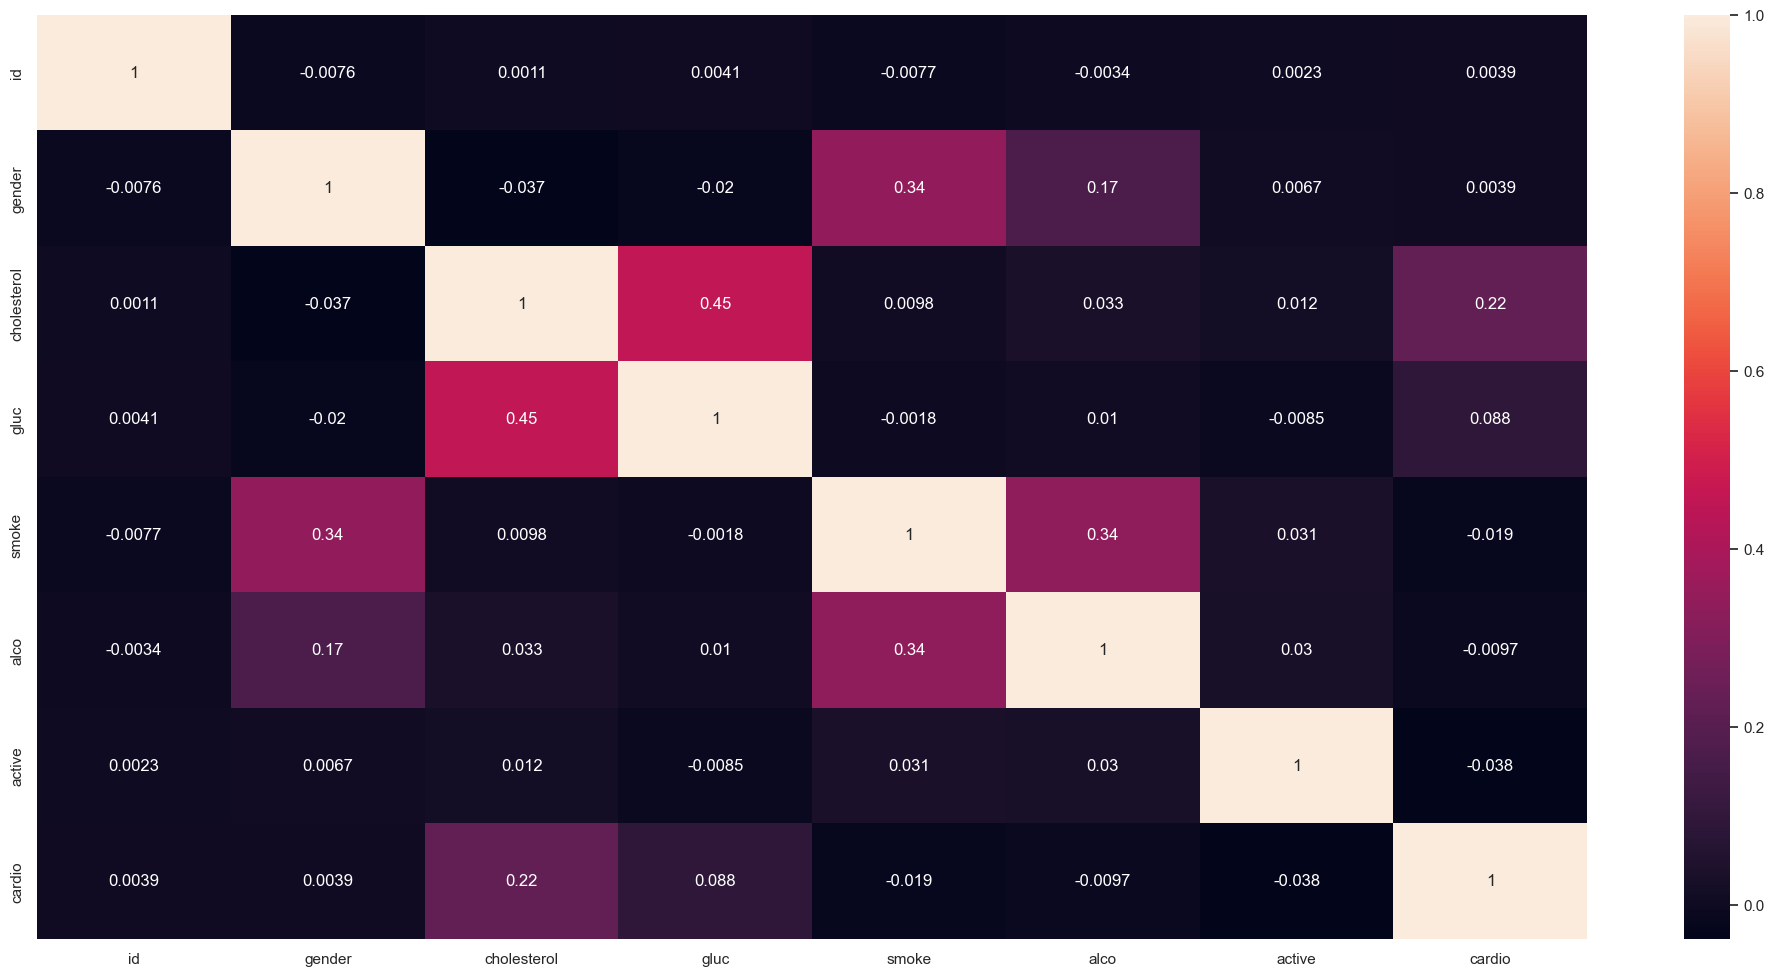

In [52]:
# Relação de Features e sua Relevância de Correlação (dataframe original)
correlation = cat_attributes.corr( method='pearson' )
sns.heatmap( correlation, annot=True );

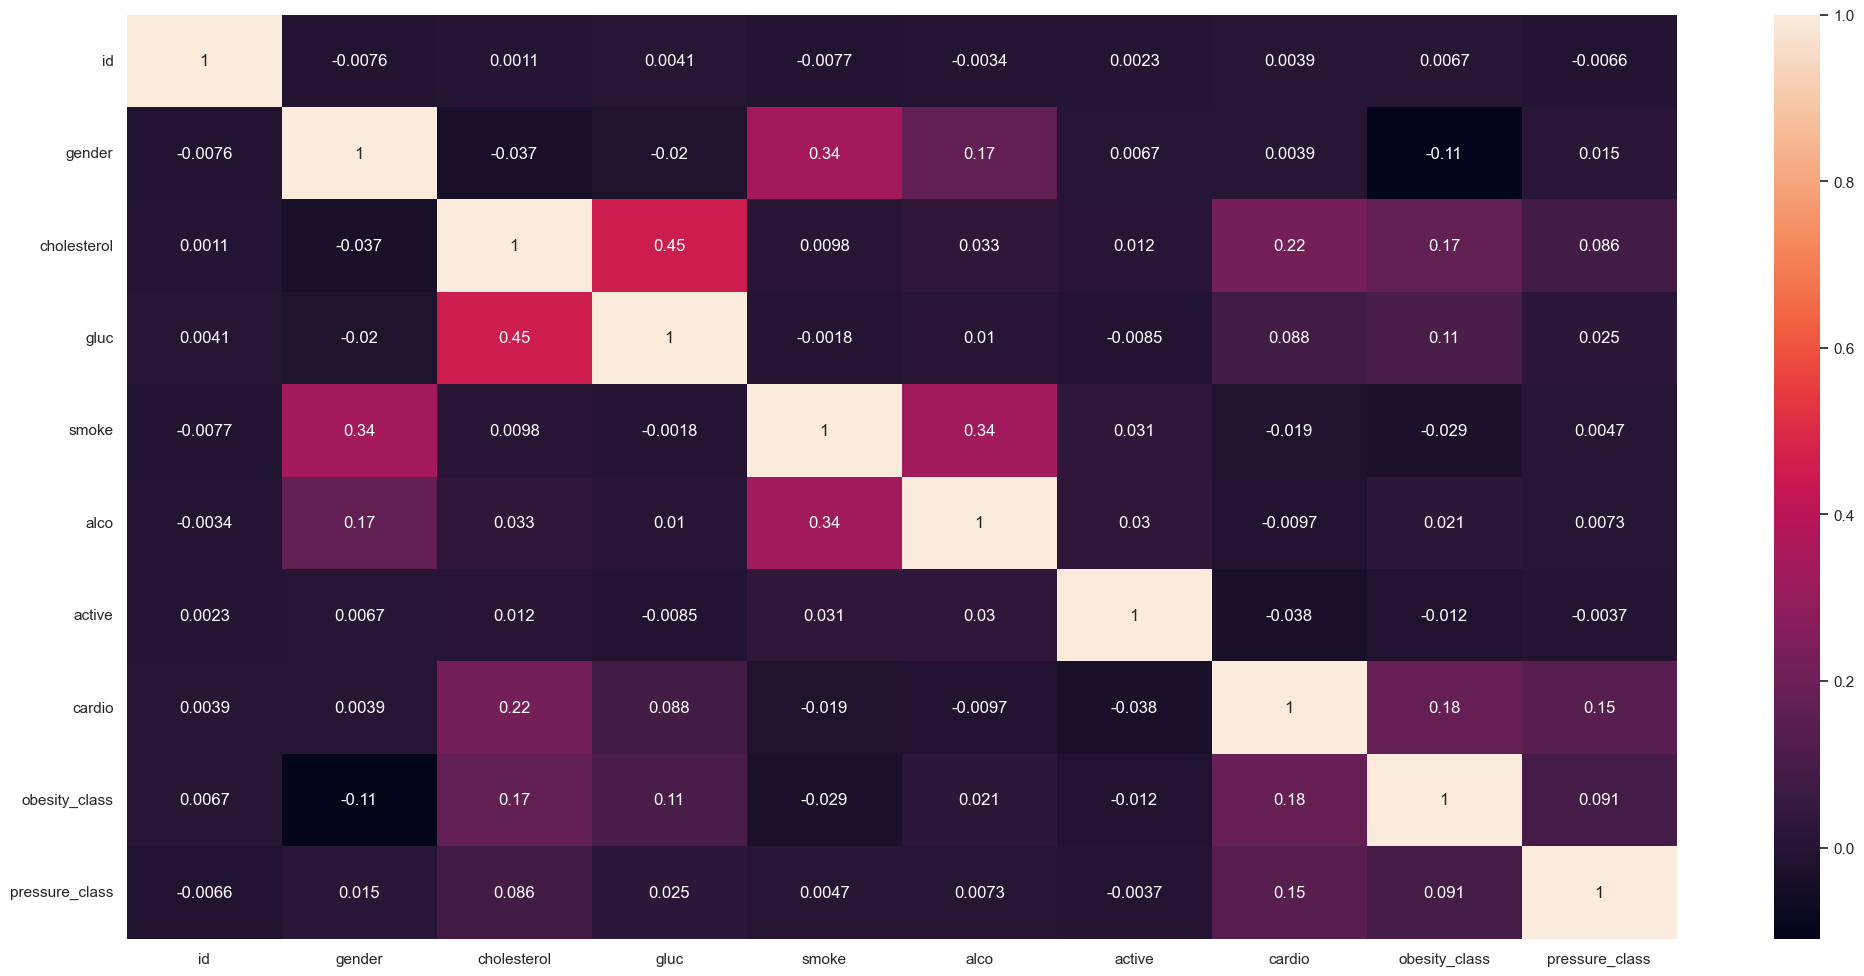

In [53]:
# Cópia Dataframe
df_432 = cat_attributes.copy()

# Adicionando novas colunas criadas no Feature Engineering
df_432 = df_432.assign(obesity_class=df4['obesity_class'], pressure_class=df4['pressure_class'])

# Relação de Features e sua Relevância de Correlação (dataframe pós Feature Engineering)
correlation = df_432.corr( method='pearson' )
sns.heatmap( correlation, annot=True );

# 5.0. Data Preparation

In [54]:
df5 = df4.copy()

## 5.1. Feature analysis

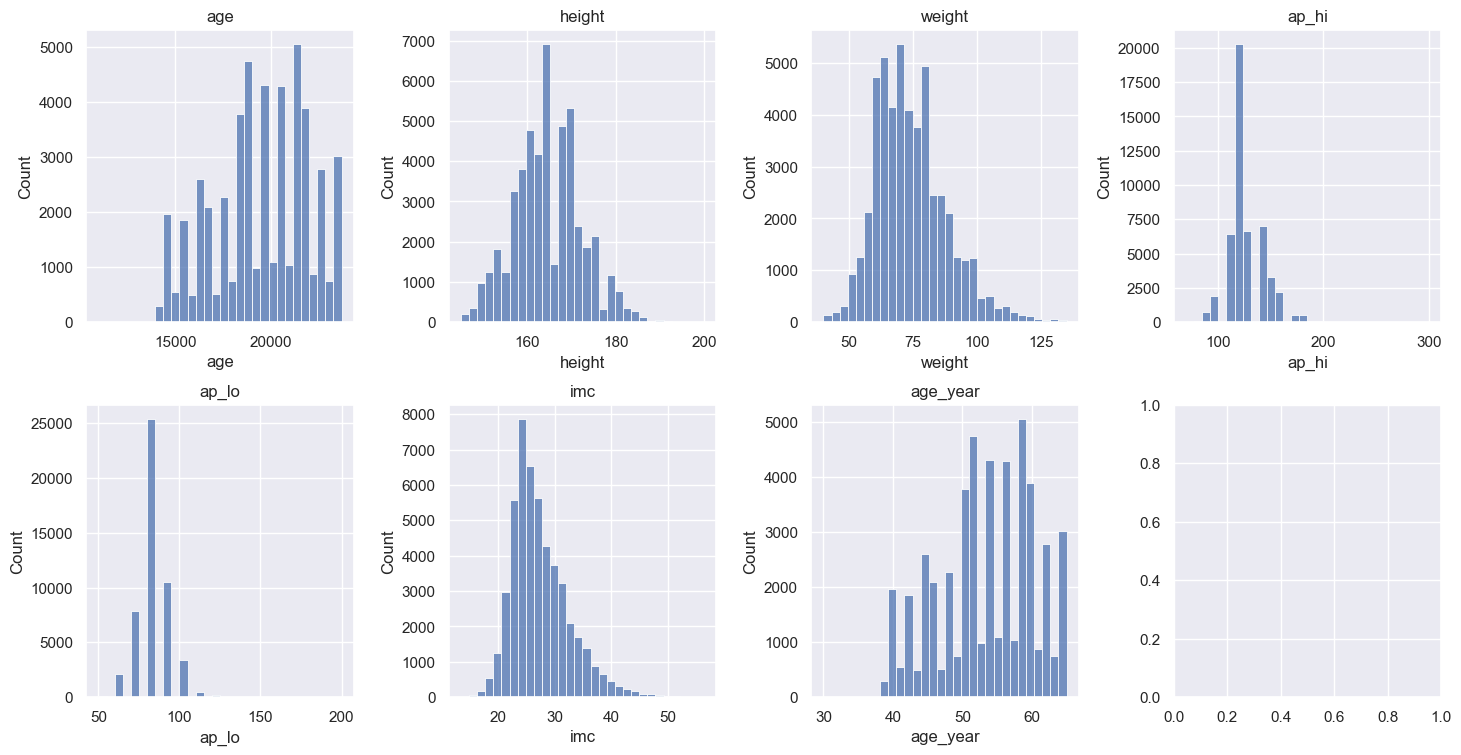

In [55]:
# Selecionar as colunas desejadas
columns = ['age', 'height', 'weight', 'ap_hi', 'ap_lo', 'imc', 'age_year']

# Definir o número de linhas e colunas do grid
num_rows = 2
num_cols = 4

# Criar a figura e os eixos do grid
fig, axes = plt.subplots(num_rows, num_cols, figsize=(15, 8))

# Ajustar o espaçamento entre os subplots
fig.tight_layout(pad=3.0)

# Plotar os gráficos de distribuição em cada eixo do grid
for i, column in enumerate(columns):
    row = i // num_cols
    col = i % num_cols
    ax = axes[row, col]
    sns.histplot(df5[column], ax=ax, bins=30)
    ax.set_title(column)

# Exibir o grid de gráficos
plt.show()

## 5.2. Feature pre-processing

In [56]:
# Aplicar transformação logarítmica
df5['imc'] = np.log(df5['imc'])
df5['weight'] = np.log(df5['weight'])
df5['height'] = np.log(df5['height'])

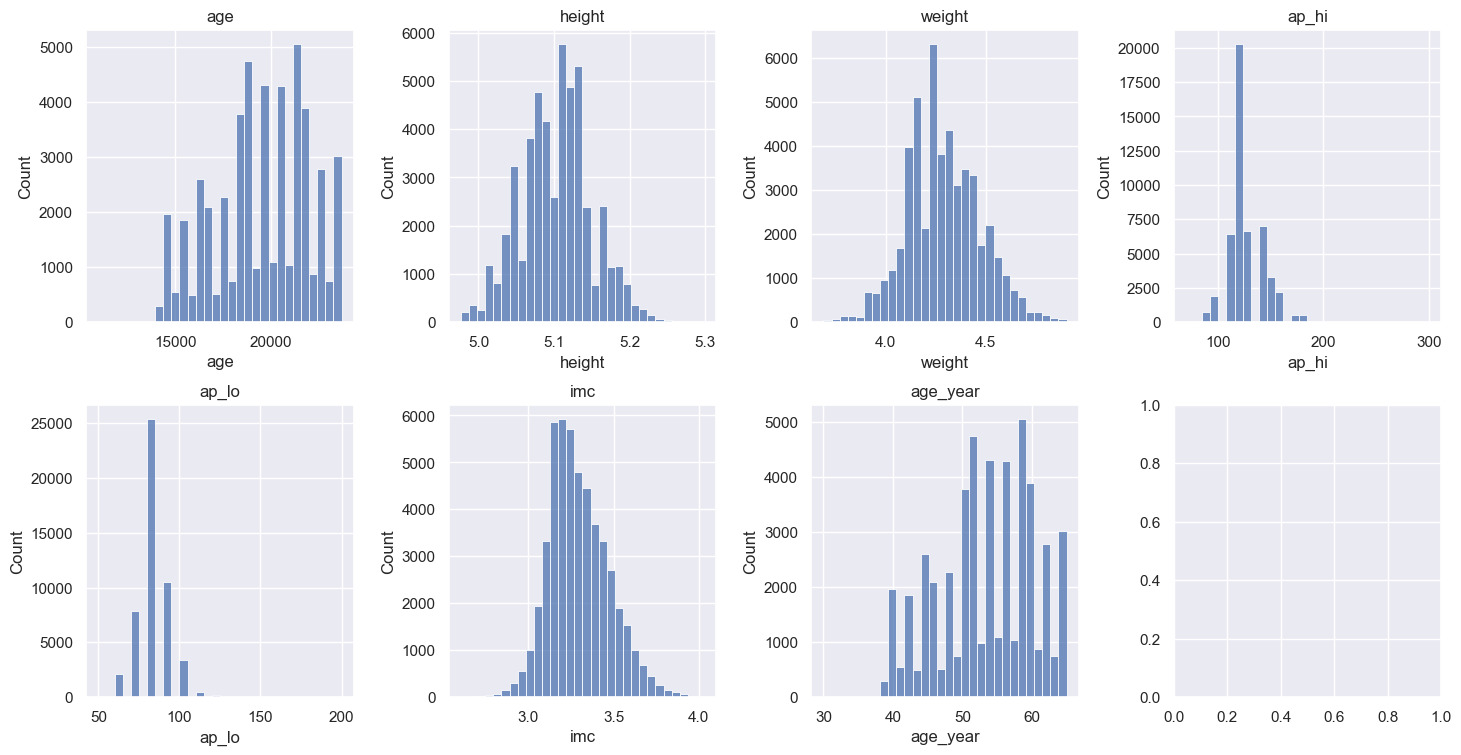

In [57]:
# Selecionar as colunas desejadas
columns = ['age', 'height', 'weight', 'ap_hi', 'ap_lo', 'imc', 'age_year']

# Definir o número de linhas e colunas do grid
num_rows = 2
num_cols = 4

# Criar a figura e os eixos do grid
fig, axes = plt.subplots(num_rows, num_cols, figsize=(15, 8))

# Ajustar o espaçamento entre os subplots
fig.tight_layout(pad=3.0)

# Plotar os gráficos de distribuição em cada eixo do grid
for i, column in enumerate(columns):
    row = i // num_cols
    col = i % num_cols
    ax = axes[row, col]
    sns.histplot(df5[column], ax=ax, bins=30)
    ax.set_title(column)

# Exibir o grid de gráficos
plt.show()

# 6.0. Feature Selection

In [58]:
df6 = df5.copy()

## 6.1. Split dataframe into training and test dataset

In [59]:
# Separar as features e o alvo
X = df6.drop('cardio', axis=1)
y = df6['cardio']

# Dividir em conjunto de treinamento e teste
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

# Verificar o tamanho dos conjuntos de treinamento e teste
print(f"Tamanho do conjunto de treinamento: {X_train.shape[0]} amostras")
print(f"Tamanho do conjunto de teste: {X_test.shape[0]} amostras")

Tamanho do conjunto de treinamento: 37500 amostras
Tamanho do conjunto de teste: 12500 amostras


In [60]:
X_train.head()

,age,height,weight,ap_hi,ap_lo,id,gender,cholesterol,gluc,smoke,alco,active,imc,age_year,obesity_class,pressure_class
27434,18980,5.093750,4.304065,120.0,70.0,39229,2,1,1,1,0,1,3.326833,52,1,0
13400,17520,5.099866,4.430817,120.0,80.0,19130,2,1,1,1,0,0,3.441379,48,2,0
883,16060,5.135798,4.248495,110.0,70.0,1232,2,1,1,0,0,1,3.187179,44,0,0
7303,18250,5.062595,4.127134,110.0,70.0,10410,1,1,1,0,0,1,3.212455,50,0,0
45124,18980,5.075174,4.110874,120.0,80.0,64444,2,1,1,1,0,1,3.170945,52,0,0


## 6.2. Boruta as Feature Selector

In [61]:
## training and test dataset for Boruta
#X_train_n = X_train.values
#y_train_n = y_train.values

## define RandomForestRegressor
#rf = RandomForestRegressor(n_jobs=-1)

## define Boruta
#boruta = BorutaPy(rf, n_estimators='auto', verbose=2, random_state=42).fit(X_train_n, y_train_n)

### 6.2.1. Best Features from Boruta

In [62]:
#cols_selected = boruta.support_.tolist()
#
## best features
#X_train_fs = X_train
#cols_selected_boruta = X_train_fs.iloc[:, cols_selected].columns.to_list() # Salvando as colunas selecionadas pelo Boruta
#
## not selected boruta
#cols_not_selected_boruta = list( np.setdiff1d( X_train_fs.columns,cols_selected_boruta ) ) # Comparando x_train_fs com cols_selected_boruta

In [63]:
cols_selected_boruta = ['id']

## 6.3. Manual Feature Selection

In [64]:
df5.columns

Index(['age', 'height', 'weight', 'ap_hi', 'ap_lo', 'id', 'gender',
       'cholesterol', 'gluc', 'smoke', 'alco', 'active', 'cardio', 'imc',
       'age_year', 'obesity_class', 'pressure_class'],
      dtype='object')

In [65]:
cols_not_selected = df5.copy()
cols_selected = df5.copy()

# Montando uma lista de Features final, levando em consideração o 'feeling' que nos foi proporcionado pela etapa de Análise de Hipoteses
cols_not_selected = cols_not_selected.drop(columns=['height', 'weight', 'ap_hi', 'ap_lo', 'age_year', 'imc', 'cholesterol'])

cols_selected = cols_selected.drop(columns=cols_not_selected.columns)

# 7.0. Machine Learning Modelling

In [66]:
# Separar as features e o alvo
X = cols_selected
y = cols_not_selected['cardio']

# Dividir em conjunto de treinamento e teste
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Verificar o tamanho dos conjuntos de treinamento e teste
print(f"Tamanho do conjunto de treinamento: {X_train.shape[0]} amostras")
print(f"Tamanho do conjunto de teste: {X_test.shape[0]} amostras")

Tamanho do conjunto de treinamento: 40000 amostras
Tamanho do conjunto de teste: 10000 amostras


## 7.1. KNN (K-Nearest Neighbors)

In [67]:
def evaluate_model(y_true, y_pred):
    # Calcula a matriz de confusão
    cm = confusion_matrix(y_true, y_pred)

    # Calcula as métricas de erro
    accuracy = accuracy_score(y_true, y_pred) * 100
    precision = precision_score(y_true, y_pred) *100
    recall = recall_score(y_true, y_pred) *100
    f1 = f1_score(y_true, y_pred) *100

    # Cria um DataFrame com as métricas
    metrics_df = pd.DataFrame({'Accuracy': [accuracy],
                               'Precision': [precision],
                               'Recall': [recall],
                               'F1-score': [f1]})

    return cm, metrics_df


# Cria o classificador KNN
knn = KNeighborsClassifier()

# Treina o modelo com os dados de treino
knn.fit(X_train, y_train)

# Realiza as previsões com os dados de teste
y_pred = knn.predict(X_test)

# Avalia o modelo
cm, metrics_df = evaluate_model(y_test, y_pred)

# Imprime a matriz de confusão
print('Matriz de Confusão:')
print(cm)

# Imprime as métricas de erro
print('Métricas de Erro:')
print(metrics_df)

Matriz de Confusão:
[[3566 1455]
 [1561 3418]]
Métricas de Erro:
   Accuracy  Precision     Recall   F1-score
0     69.84  70.141597  68.648323  69.386927


### 7.1.1. Cross Validation KNN (K-Nearest Neighbors)

In [68]:
# Cria uma lista para armazenar os resultados de cada fold
fold_scores = []

# Cria o classificador KNN
knn = KNeighborsClassifier()

# Realiza a validação cruzada com 5 folds
scores = cross_val_score(knn, X_train, y_train, cv=5) * 100

# Itera sobre os scores de cada fold
for i, score in enumerate(scores):
    fold_scores.append({'Fold': f'k{i+1}', 'Score': score})

# Calcula a média dos scores
mean_score = scores.mean()
fold_scores.append({'Fold': 'Mean', 'Score': mean_score})

# Cria um DataFrame com os resultados
df_scores = pd.DataFrame(fold_scores)

# Imprime a tabela de resultados
df_scores

,Fold,Score
0,k1,69.3875
1,k2,69.2625
2,k3,69.8500
3,k4,69.1500
4,k5,70.0750
5,Mean,69.5450


## 7.2. Logistic Regression

In [69]:
def evaluate_model(y_true, y_pred):
    # Calcula a matriz de confusão
    cm = confusion_matrix(y_true, y_pred)

    # Calcula as métricas de erro
    accuracy = accuracy_score(y_true, y_pred) *100
    precision = precision_score(y_true, y_pred) *100
    recall = recall_score(y_true, y_pred) *100
    f1 = f1_score(y_true, y_pred) *100

    # Cria um DataFrame com as métricas
    metrics_df = pd.DataFrame({'Accuracy': [accuracy],
                               'Precision': [precision],
                               'Recall': [recall],
                               'F1-score': [f1]})

    return cm, metrics_df


# Cria o classificador de Regressão Logística
logreg = LogisticRegression(max_iter=1000)

# Treina o modelo com os dados de treino
logreg.fit(X_train, y_train)

# Realiza as previsões com os dados de teste
y_pred = logreg.predict(X_test)

# Avalia o modelo
cm, metrics_df = evaluate_model(y_test, y_pred)

# Imprime a matriz de confusão
print('Matriz de Confusão:')
print(cm)

# Imprime as métricas de erro
print('Métricas de Erro:')
print(metrics_df)

Matriz de Confusão:
[[3967 1054]
 [1594 3385]]
Métricas de Erro:
   Accuracy  Precision     Recall   F1-score
0     73.52  76.255913  67.985539  71.883627


### 7.2.1. Cross Validation Logistic Regression

In [70]:
# Cria uma lista para armazenar os resultados de cada fold
fold_scores = []

# Cria o classificador de Regressão Logística
logreg = LogisticRegression(max_iter=1000)

# Realiza a validação cruzada com 5 folds
scores = cross_val_score(logreg, X_train, y_train, cv=5) * 100

# Itera sobre os scores de cada fold
for i, score in enumerate(scores):
    fold_scores.append({'Fold': f'k{i+1}', 'Score': score})

# Calcula a média dos scores
mean_score = scores.mean()
fold_scores.append({'Fold': 'Mean', 'Score': mean_score})

# Cria um DataFrame com os resultados
df_scores = pd.DataFrame(fold_scores)

# Imprime a tabela de resultados
df_scores

,Fold,Score
0,k1,72.3250
1,k2,72.1625
2,k3,72.9375
3,k4,71.4000
4,k5,73.9375
5,Mean,72.5525


## 7.3. Decision Tree

In [71]:
def evaluate_model(y_true, y_pred):
    # Calcula a matriz de confusão
    cm = confusion_matrix(y_true, y_pred)

    # Calcula as métricas de erro
    accuracy = accuracy_score(y_true, y_pred) *100
    precision = precision_score(y_true, y_pred) *100
    recall = recall_score(y_true, y_pred) *100
    f1 = f1_score(y_true, y_pred) *100

    # Cria um DataFrame com as métricas
    metrics_df = pd.DataFrame({'Accuracy': [accuracy],
                               'Precision': [precision],
                               'Recall': [recall],
                               'F1-score': [f1]})

    return cm, metrics_df


# Cria o classificador de Árvore de Decisão
dt = DecisionTreeClassifier()

# Treina o modelo com os dados de treino
dt.fit(X_train, y_train)

# Realiza as previsões com os dados de teste
y_pred = dt.predict(X_test)

# Avalia o modelo
cm, metrics_df = evaluate_model(y_test, y_pred)

# Imprime a matriz de confusão
print('Matriz de Confusão:')
print(cm)

# Imprime as métricas de erro
print('Métricas de Erro:')
print(metrics_df)

Matriz de Confusão:
[[3376 1645]
 [1965 3014]]
Métricas de Erro:
   Accuracy  Precision     Recall   F1-score
0      63.9  64.691994  60.534244  62.544096


### 7.3.1. Cross Validation Decision Tree

In [72]:
# Cria uma lista para armazenar os resultados de cada fold
fold_scores = []

# Cria o classificador de Árvore de Decisão
dt = DecisionTreeClassifier()

# Realiza a validação cruzada com 5 folds
scores = cross_val_score(dt, X_train, y_train, cv=5) * 100

# Itera sobre os scores de cada fold
for i, score in enumerate(scores):
    fold_scores.append({'Fold': f'k{i+1}', 'Score': score})

# Calcula a média dos scores
mean_score = scores.mean()
fold_scores.append({'Fold': 'Mean', 'Score': mean_score})

# Cria um DataFrame com os resultados
df_scores = pd.DataFrame(fold_scores)

# Imprime a tabela de resultados
df_scores

,Fold,Score
0,k1,63.7000
1,k2,62.5500
2,k3,63.2625
3,k4,63.7125
4,k5,64.0750
5,Mean,63.4600


# 8.0. Fine Tunning

## 8.1. Grid Search | Logistic Regression

In [73]:
## Define os parâmetros a serem testados
#parameters = {'C': [0.1, 1.0, 10.0],
#              'penalty': ['l1', 'l2']}
#
## Cria o classificador de Regressão Logística
#logreg = LogisticRegression(max_iter=1000, solver='liblinear')
#
## Realiza a busca em grid com validação cruzada
#grid_search = GridSearchCV(logreg, parameters, cv=5)
#grid_search.fit(X_train, y_train)
#
## Obtém os melhores parâmetros encontrados
#best_params = grid_search.best_params_

In [74]:
logreg_best = LogisticRegression(C=0.1, max_iter=1000, penalty='l1', solver='liblinear')

## 8.2 Final Model

In [75]:
def evaluate_model(y_true, y_pred):
    # Calcula a matriz de confusão
    cm = confusion_matrix(y_true, y_pred)

    # Calcula as métricas de erro
    accuracy = accuracy_score(y_true, y_pred) *100
    precision = precision_score(y_true, y_pred) *100
    recall = recall_score(y_true, y_pred) *100
    f1 = f1_score(y_true, y_pred) *100

    # Cria um DataFrame com as métricas
    metrics_df = pd.DataFrame({'Accuracy': [accuracy],
                               'Precision': [precision],
                               'Recall': [recall],
                               'F1-score': [f1]})

    return cm, metrics_df

# Treina o modelo com os dados de treino
logreg_best.fit(X_train, y_train)

# Realiza as previsões com os dados de teste
y_pred = logreg_best.predict(X_test)

# Avalia o modelo
cm, metrics_df = evaluate_model(y_test, y_pred)

# Imprime a matriz de confusão
print('Matriz de Confusão:')
print(cm)

# Imprime as métricas de erro
print('Métricas de Erro:')
print(metrics_df)

Matriz de Confusão:
[[3971 1050]
 [1596 3383]]
Métricas de Erro:
   Accuracy  Precision     Recall   F1-score
0     73.54  76.314009  67.945371  71.886953


### 8.1.1. Cross Validation Logistic Regression - Best Parameters

In [76]:
# Cria uma lista para armazenar os resultados de cada fold
fold_scores = []

# Realiza a validação cruzada com 5 folds
scores = cross_val_score(logreg_best, X_train, y_train, cv=5) * 100

# Itera sobre os scores de cada fold
for i, score in enumerate(scores):
    fold_scores.append({'Fold': f'k{i+1}', 'Score': score})

# Calcula a média dos scores
mean_score = scores.mean()
fold_scores.append({'Fold': 'Mean', 'Score': mean_score})

# Cria um DataFrame com os resultados
df_scores = pd.DataFrame(fold_scores)

# Imprime a tabela de resultados
df_scores

,Fold,Score
0,k1,72.3125
1,k2,72.1500
2,k3,73.1000
3,k4,71.7250
4,k5,73.9500
5,Mean,72.6475


## 8.2. Save Final Model

In [77]:
# Save Trained Model
pickle.dump( logreg_best, open(r'C:\\Users\\usuario\\Documents\\projetos\\PA_001\\model\\model_cardio.pkl', 'wb' ) )

# 9.0. Error Translation and Interpretation

In [78]:
df9 = X_test.copy()

## 9.1. Data Preparation Reversal

In [79]:
# Adicionar predições geradas ao Dataframe
df9['prediction'] = y_pred
df9['cardio']     = y_test 

# Reverter transformação logarítmica
df9['imc'] = np.expm1(df9['imc'])
df9['weight'] = np.expm1(df9['weight'])
df9['height'] = np.expm1(df9['height'])

## 9.2. Business indicators

In [80]:
# Parâmetros BI
precision_pred  = 0.7142
med_corr        = 100
med_prev        = 50

n_total         = df9['height'].shape[0]
pred_cardio     = df9['prediction'].value_counts()[1]
error           = pred_cardio*((1-precision_pred))
pred_desc_error = pred_cardio - error
pred_add_error  = pred_cardio + error

result_sce_1    = (pred_desc_error*med_corr) - ((pred_cardio*med_prev)+(error*med_prev))
result_sce_2    = (pred_add_error*med_corr)  - ((pred_cardio*med_prev)+(error*med_corr))

# Criar os dados das tabelas
dados = {
    'Descrição': ['Cenário Predição > Real', 'Cenário Predição < Real'],
    'Predição': [pred_cardio, pred_cardio],
    'Real': [pred_desc_error, pred_add_error],
    'Erro': [error, (-error)],
    'Custo Med. Preventiva (-)': [(pred_cardio*med_prev), (pred_cardio*med_prev)],
    'Custo Med. Corretiva (-)': [(pred_desc_error*med_corr), (pred_add_error*med_corr)],
    'Custo Erro (-)': [(error*med_prev), (error*med_corr)],
    'Resultado (=)': [result_sce_1, result_sce_2]}

In [81]:
# Criar o DataFrame com os dados
df = pd.DataFrame(dados)

# Incluir informações adicionais
info_adicionais = {
    'Descrição': ['Número Total Pessoas', 'Precisão Predição', 'Custo Med. Corretiva p/ pessoa', 'Custo Med. Preventiva p/ pessoa'],
    'Valores': [n_total, f"{precision_pred*100:.2f}%", 'R$ 100,00', 'R$ 50,00']}

df_info_adicionais = pd.DataFrame(info_adicionais)

# Ordenar as tabelas
df = df.sort_values(by='Descrição')
df_info_adicionais = df_info_adicionais.sort_values(by='Descrição')

# Converter os DataFrames em tabelas formatadas
tabela_formatada = tabulate(df, headers='keys', tablefmt='github', showindex=False)
tabela_info_adicionais = tabulate(df_info_adicionais, headers='keys', tablefmt='github', showindex=False)

# Imprimir as tabelas formatadas
print("Informações Adicionais:")
print(tabela_info_adicionais)
print("\nTabela de Cenários:")
print(tabela_formatada)

Informações Adicionais:
| Descrição                       | Valores   |
|---------------------------------|-----------|
| Custo Med. Corretiva p/ pessoa  | R$ 100,00 |
| Custo Med. Preventiva p/ pessoa | R$ 50,00  |
| Número Total Pessoas            | 10000     |
| Precisão Predição               | 71.42%    |

Tabela de Cenários:
| Descrição               |   Predição |    Real |     Erro |   Custo Med. Preventiva (-) |   Custo Med. Corretiva (-) |   Custo Erro (-) |   Resultado (=) |
|-------------------------|------------|---------|----------|-----------------------------|----------------------------|------------------|-----------------|
| Cenário Predição < Real |       4433 | 5699.95 | -1266.95 |                      221650 |                     569995 |         126695   |        221650   |
| Cenário Predição > Real |       4433 | 3166.05 |  1266.95 |                      221650 |                     316605 |          63347.6 |         31607.3 |


## 9.3. Machine Learning Performance

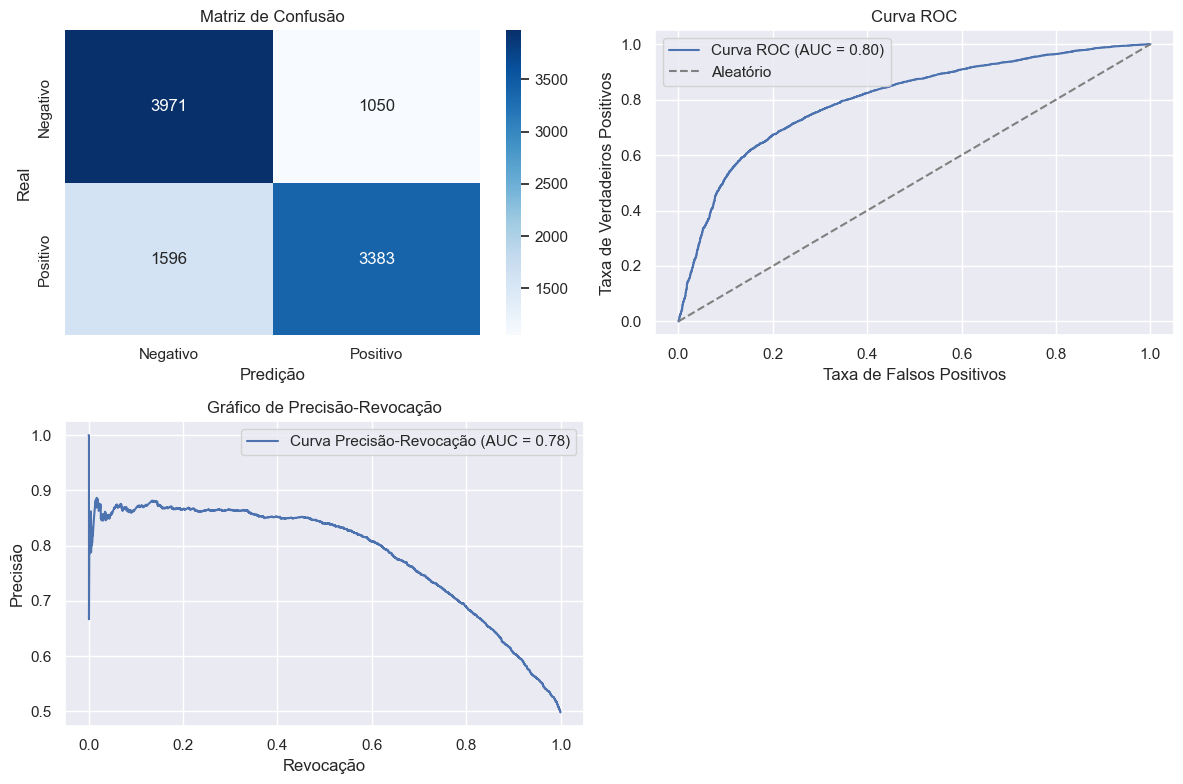

In [82]:
# Cria uma figura e os subplots
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(12, 8))

# Plot 1: Matriz de Confusão
confusion_matrix = pd.crosstab(df9['cardio'], df9['prediction'])
class_labels = ['Negativo', 'Positivo'] # Define os rótulos das classes
sns.heatmap(confusion_matrix, annot=True, fmt='.0f', cmap='Blues', ax=axes[0, 0], xticklabels=class_labels, yticklabels=class_labels)
axes[0, 0].set_title('Matriz de Confusão')
axes[0, 0].set_xlabel('Predição')
axes[0, 0].set_ylabel('Real')

# Plot 2: Curva ROC
probs = logreg_best.predict_proba(X_test)[:, 1]
fpr, tpr, thresholds = roc_curve(y_test, probs)
roc_auc = roc_auc_score(y_test, probs)  # Renomear a variável para "roc_auc"
axes[0, 1].plot(fpr, tpr, label='Curva ROC (AUC = {:.2f})'.format(roc_auc))
axes[0, 1].plot([0, 1], [0, 1], linestyle='--', color='gray', label='Aleatório')
axes[0, 1].set_xlabel('Taxa de Falsos Positivos')
axes[0, 1].set_ylabel('Taxa de Verdadeiros Positivos')
axes[0, 1].set_title('Curva ROC')
axes[0, 1].legend()

# Plot 3: Gráfico de Precisão-Revocação
precision, recall, thresholds = precision_recall_curve(y_test, probs)
pr_auc = auc(recall, precision)  # Renomear a variável para "pr_auc"
axes[1, 0].plot(recall, precision, label='Curva Precisão-Revocação (AUC = {:.2f})'.format(pr_auc))
axes[1, 0].set_xlabel('Revocação')
axes[1, 0].set_ylabel('Precisão')
axes[1, 0].set_title('Gráfico de Precisão-Revocação')
axes[1, 0].legend()

# Remove o subplot vazio
fig.delaxes(axes[1, 1])

# Ajusta a posição dos subplots
plt.tight_layout()

# Mostra a figura
plt.show()

# 10.0. Deploy Model To Production

## 10.1. Predict

In [83]:
# 0.0 Import's
import pandas     as pd
import numpy      as np
import seaborn    as sns
import inflection

from sklearn.ensemble        import RandomForestRegressor
from sklearn.neighbors       import KNeighborsClassifier
from sklearn.linear_model    import LogisticRegression
from sklearn.tree            import DecisionTreeClassifier
from sklearn.metrics         import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score
from sklearn.model_selection import cross_val_score

from tabulate                import tabulate
from matplotlib              import pyplot as plt
from IPython.display         import Image
from IPython.core.display    import HTML

# 1.0. Importando Dataset's
df1 = pd.read_csv(r'C:\Users\usuario\Documents\projetos\PA_001\dataset\cardio_test.csv', delimiter=';')

# 2.0 Funções de Limpeza/Pré Processamento

def cleaning (df1):
    # Verificar o comprimento dos valores na coluna 'ap_hi'
    comprimentos = df1['ap_hi'].astype(str).str.len()
    
    # Tratamento len = 1
    df1.loc[comprimentos == 1, 'ap_hi'] = df1.loc[comprimentos == 1, 'ap_hi'] * 10
    
    # Tratamento len = 2
    df1.loc[comprimentos == 2, 'ap_hi'] = (df1.loc[comprimentos == 2, 'ap_hi'] // 10).round() * 10
    
    # Tratamento len = 3
    df1.loc[comprimentos == 3, 'ap_hi'] = (df1.loc[comprimentos == 3, 'ap_hi'] // 10).round() * 10
    
    # Tratamento len = 4
    df1.loc[comprimentos == 4, 'ap_hi'] = (df1.loc[comprimentos == 4, 'ap_hi'] // 100).round() * 10
    
    # Tratamento len = 5
    df1.loc[comprimentos == 5, 'ap_hi'] = (df1.loc[comprimentos == 5, 'ap_hi'] // 1000).round() * 10
    
    # Verificar o comprimento dos valores na coluna 'ap_li'
    comprimentos = df1['ap_lo'].astype(str).str.len()
    
    # Tratamento len = 1
    df1.loc[comprimentos == 1, 'ap_lo'] = df1.loc[comprimentos == 1, 'ap_lo'] * 10
    
    # Tratamento len = 2
    df1.loc[comprimentos == 2, 'ap_lo'] = (df1.loc[comprimentos == 2, 'ap_lo'] // 10).round() * 10
    
    # Tratamento len = 3
    df1.loc[comprimentos == 3, 'ap_lo'] = (df1.loc[comprimentos == 3, 'ap_lo'] // 10).round() * 10
    
    # Tratamento len = 4
    df1.loc[comprimentos == 4, 'ap_lo'] = (df1.loc[comprimentos == 4, 'ap_lo'] // 100).round() * 10
    
    # Tratamento len = 5
    df1.loc[comprimentos == 5, 'ap_lo'] = (df1.loc[comprimentos == 5, 'ap_lo'] // 1000).round() * 10
    
    
    # Separando as variáveis em Númericas e Categóricas
    num_attributes = df1.drop(['id', 'gender', 'cholesterol', 'gluc', 'smoke', 'alco', 'active'], axis=1)
    cat_attributes = df1.drop(['age', 'height', 'weight', 'ap_hi', 'ap_lo'], axis=1)

    # Convertendo a coluna age em ano e removendo do dataframe desconsiderando da análise de outlier's 
    num_attributes['age'] = (num_attributes['age'] / 365).round().astype('int64')
     
    # Lista para armazenar os resultados
    results = []
    
    # Itera sobre as colunas do DataFrame
    for column in num_attributes.columns:
        # Calcula os quartis
        min =  num_attributes[column].min()
        max =  num_attributes[column].max()
        mean = num_attributes[column].mean().round()
        q1 = num_attributes[column].quantile(0.25)
        q3 = num_attributes[column].quantile(0.75)
    
        # Calcula o IQR
        iqr = q3 - q1
    
        # Calcula os limites inferior e superior
        lower_limit = q1 - 1.5 * iqr
        upper_limit = q3 + 1.5 * iqr
    
        # Filtra os valores que estão abaixo do limite inferior e acima do limite superior
        outliers_below = num_attributes[num_attributes[column] < lower_limit]
        outliers_above = num_attributes[num_attributes[column] > upper_limit]
    
        # Conta a quantidade de outliers abaixo e acima dos limites
        count_below = len(outliers_below)
        count_above = len(outliers_above)
    
        # Cria um dicionário com os resultados
        result = {
            'Feature': column,
            'Mínimo': min,
            'Máximo': max,
            'Média': mean,
            'Limite Inferior': lower_limit,
            'Limite Superior': upper_limit,
            'Outliers abaixo': count_below,
            'Outliers acima': count_above
        }
    
        # Adiciona o dicionário à lista de resultados
        results.append(result)
        
    # Definir os limites das faixas etárias
    age_bins = [30, 35, 40, 45, 50, 55, 60, 65, np.inf]
    
    # Definir os rótulos das faixas etárias
    age_labels = ['30-34', '35-39', '40-44', '45-49', '50-54', '55-59', '60-64', '65-70']
    
    # Adicionar uma nova coluna com as faixas etárias correspondentes
    num_attributes['age_group'] = pd.cut(num_attributes['age'], bins=age_bins, labels=age_labels, right=False)
    
    # Limites coluna height
    lower_limit = 145
    upper_limit = 200
    
    # função para substituir os valores fora do limite pela mediana da faixa etária correspondente
    def replace_outliers_height(row):
        if row['height'] < lower_limit or row['height'] > upper_limit:
            median_height = num_attributes.loc[num_attributes['age_group'] == row['age_group'], 'height'].median()
            return median_height
        return row['height']
    
    # Aplicando função
    num_attributes['height'] = num_attributes.apply(replace_outliers_height, axis=1)

    # Limites coluna weight
    lower_limit = 40.00
    upper_limit = 135.00
    
    # função para substituir os valores fora do limite pela mediana da faixa etária correspondente
    def replace_outliers_weight(row):
        if row['weight'] < lower_limit or row['weight'] > upper_limit:
            median_weight = num_attributes.loc[num_attributes['age_group'] == row['age_group'], 'weight'].median()
            return median_weight
        return row['weight']
    
    # Aplicando função
    num_attributes['weight'] = num_attributes.apply(replace_outliers_weight, axis=1)

    # Limites coluna ap_hi
    lower_limit = 70
    upper_limit = 300
    
    # função para substituir os valores fora do limite pela mediana da faixa etária correspondente
    def replace_outliers_ap_hi(row):
        if row['ap_hi'] < lower_limit or row['ap_hi'] > upper_limit:
            median_ap_hi = num_attributes.loc[num_attributes['age_group'] == row['age_group'], 'ap_hi'].median()
            return median_ap_hi
        return row['ap_hi']
    
    # Aplicando função
    num_attributes['ap_hi'] = num_attributes.apply(replace_outliers_ap_hi, axis=1)

    # Limites coluna ap_lo
    lower_limit = 50
    upper_limit = 200
    
    # função para substituir os valores fora do limite pela mediana da faixa etária correspondente
    def replace_outliers_ap_lo(row):
        if row['ap_lo'] < lower_limit or row['ap_lo'] > upper_limit:
            median_ap_lo = num_attributes.loc[num_attributes['age_group'] == row['age_group'], 'ap_lo'].median()
            return median_ap_lo
        return row['ap_lo']
    
    # Aplicando função
    num_attributes['ap_lo'] = num_attributes.apply(replace_outliers_ap_lo, axis=1)

    # Convertendo a coluna age em dias
    num_attributes['age'] = (num_attributes['age'] * 365).round().astype('int64')
    
    # Realizando merge entre os dataframes
    df1 = pd.concat([num_attributes, cat_attributes], axis=1)
    
    return df1

def feature_eng (df1):
    # Criação da nova coluna [IMC]
    df1['imc'] = (df1['weight'] / ((df1['height'] / 100) ** 2)).round(2)
    
    # Criação da nova coluna idade em anos [age_year]
    df1['age_year'] = (df1['age'] / 365).round().astype('int64')
    
    # Criação da nova coluna de classificação da obesidade [obesity_class]
    df1['obesity_class'] = pd.cut(df1['imc'], bins=[-float('inf'), 18.5, 24.9, 29.9, 34.9, 39.9, float('inf')],
                                 labels=[-1, 0, 1, 2, 3, 4]).astype('int64')
    
    # Definir as faixas de pressão arterial por idade
    age_bins = [0, 18, 30, 40, 50, 60, np.inf]
    pressure_bins = [[85, 130], [85, 130], [90, 140], [100, 160], [110, 180], [90, 140]]
    
    # Função para classificar a pressão arterial
    def classify_pressure(row):
        age = row['age_year']
        sys_pressure = row['ap_hi']
        dia_pressure = row['ap_lo']
        
        # Encontrar a faixa etária correspondente
        age_group = pd.cut([age], bins=age_bins, labels=False, right=False)[0]
        
        # Encontrar a classificação da pressão arterial
        pressure_class = 0
        sys_min, sys_max = pressure_bins[age_group]
        dia_min, dia_max = pressure_bins[age_group]
        if sys_min <= sys_pressure <= sys_max and dia_min <= dia_pressure <= dia_max:
            pressure_class = 1
        
        return pressure_class
    
    # Criar a nova coluna de classificação da pressão arterial
    df1['pressure_class'] = df1.apply(classify_pressure, axis=1)
    
    return df1

def feature_pre_processing(df1):
    # Aplicar transformação logarítmica
    df1['imc'] = np.log(df1['imc'])
    df1['weight'] = np.log(df1['weight'])
    df1['height'] = np.log(df1['height'])

    cols_not_selected = df1.drop(columns=['height', 'weight', 'ap_hi', 'ap_lo', 'age_year', 'imc', 'cholesterol'])
    cols_selected = df1.drop(columns=cols_not_selected.columns)
    
    return cols_selected, cols_not_selected

# 3.0. Carregando modelo Treinado
model = pickle.load( open( r'C:\\Users\\usuario\\Documents\\projetos\\PA_001\\model\\model_cardio.pkl', 'rb'))

# 4.0. Aplicando a Predição

# Pré-processamento
df_processed = cleaning(df1)
df_processed = feature_eng(df_processed)
cols_selected, cols_not_selected = feature_pre_processing(df_processed)

# Realizar as predições
X_test = cols_selected.copy()
predictions = model.predict(X_test)

# Adicionar as predições ao dataframe
cols_selected['predict'] = predictions

# Reverter transformação logarítmica
cols_selected['imc'] = np.expm1(cols_selected['imc']).round(2)
cols_selected['weight'] = np.expm1(cols_selected['weight']).round(2)
cols_selected['height'] = (np.expm1(cols_selected['height']) / 100).round(2)

# Realizar o merge com as colunas não selecionadas
df_merged = pd.concat([cols_not_selected, cols_selected], axis=1)

# Carregar o arquivo "cardio_data" em um DataFrame
df_cardio_data = pd.read_csv(r'C:\Users\usuario\Documents\projetos\PA_001\dataset\cardio_data.csv', delimiter=';')

# Selecionar colunas relevantes do "df_cardio_data"
df_cardio_data = df_cardio_data[['id', 'email', 'type_plan', 'city']]

# Realizar a mesclagem (merge) entre os DataFrames
df_final = pd.merge(df_merged, df_cardio_data, on='id')

# Reordenar as colunas do DataFrame df_final
column_order = ['id', 'age', 'gender', 'height', 'weight', 'ap_hi', 'ap_lo',
                'cholesterol', 'gluc', 'smoke', 'alco', 'active', 'age_year',
                'age_group', 'imc', 'obesity_class', 'pressure_class', 'email', 'type_plan', 'city', 'predict']

df_final = df_final.reindex(columns=column_order)

# Salvar o DataFrame df_final em um arquivo Excel
df_final.to_excel(r'C:\Users\usuario\Documents\projetos\PA_001\prediction\cardio_predictions.xlsx', index=False)

## 10.2. Dashboard Streamlit

In [ ]:
## Criação Nome da Página
#st.set_page_config(page_title = 'Predição Doenças Cardio')
#
#image = Image.open('images\cardio_ft.png')
#
## Definir a barra lateral (sidebar) no Streamlit
#st.sidebar.image( image, width = 180)
#st.sidebar.markdown('# Predição Doenças Cardiovasculares')
#st.sidebar.markdown("""---""")
#
## Função para filtrar o DataFrame com base no tipo de visão selecionado
#def filter_data(df_final, visao):
#    if 'Cardio' in visao and 'Não Cardio' in visao:
#        return df_final  # Retorna o DataFrame completo se ambas as visões estiverem selecionadas
#    elif 'Cardio' in visao:
#        return df_final[df_final['predict'] == 1]  # Retorna apenas os pacientes cardio
#    elif 'Não Cardio' in visao:
#        return df_final[df_final['predict'] == 0]  # Retorna apenas os pacientes não cardio
#    else:
#        return df_final
#
## Obter o tipo de visão selecionado
#visao = st.sidebar.multiselect('Escolha o Tipo de Visão', ['Cardio', 'Não Cardio'])
#
## Filtrar o DataFrame com base no tipo de visão selecionado
#df_filtered = filter_data(df_final, visao)    
#    
## Converter o DataFrame para um arquivo Excel em memória
#excel_buffer = io.BytesIO()
#df_final.to_excel(excel_buffer, index=False)
#excel_data = excel_buffer.getvalue()
#
## Definir Opção de Download
#st.sidebar.title('Opções')
#st.sidebar.write('Clique no botão abaixo para fazer o download do arquivo Excel.')
#st.sidebar.download_button(label='Download Excel', data=excel_data, file_name='df_final.xlsx')
#
#st.sidebar.markdown("""---""")
#st.sidebar.markdown('## Powered By Luiz Zamian')
#
## Definição Estrutura principal Dash
#st.write(" ## Predição de Doenças Cardiovasculares")
#
#st.markdown("""---""")
#
## Total de Pacientes
#total_pacientes = df_filtered.shape[0]
#
## Predição Cardio
#predicao_cardio = df_filtered['predict'].sum()
#
## Pacientes Não Cardio
#pacientes_nao_cardio = total_pacientes - predicao_cardio
#
## Precisão do Algoritmo
#precisao_algoritmo = 75.00
#
## Média Pressão Sistólica
#mean_sist = df_filtered['ap_hi'].mean().round()
#
## Média Pressão Sistólica
#mean_diast = df_filtered['ap_lo'].mean().round()
#
## Criação dos rótulos
#col1, col2, col3, col4 = st.columns(4)
#
#with col1:
#    st.metric(label="Total de Pacientes", value=total_pacientes)
#with col2:
#    st.metric(label="Predição Cardio", value=predicao_cardio)
#with col3:
#    st.metric(label="Pacientes Não Cardio", value=pacientes_nao_cardio)
#with col4:
#    st.metric(label="Precisão do Algoritmo", value="{:.2f}%".format(precisao_algoritmo))
#
#
## Criação dos rótulos
#col5, col6 = st.columns(2)
#
#with col5:
#    st.metric(label="Média Pressão Sistólica", value=mean_sist)
#with col6:
#    st.metric(label="Média Pressão Diastólica", value=mean_diast)
#
#
## Dicionário de mapeamento para as legendas
#legend_mapping = {0: "Não Cardio", 1: "Cardio"}
#
## Configurar as cores dos gráficos
#colors = []
#if 'Cardio' in visao and 'Não Cardio' in visao:
#    colors = ['blue', 'red']  # Cardio = vermelho, Não Cardio = azul
#elif 'Cardio' in visao:
#    colors = ['red']  # Cardio = vermelho
#elif 'Não Cardio' in visao:
#    colors = ['blue']  # Não Cardio = azul
#else:
#    colors = ['blue', 'red']  # Padrão: Cardio = vermelho, Não Cardio = azul
#
## Criação dos dois quadrantes
#col2, col3 = st.columns(2)
#
## Tamanho dos gráficos
#fig_width = 10
#fig_height = 10
#
## Tamanho da fonte dos rótulos
#label_fontsize = 18
#
## Tamanho da fonte dos valores percentuais
#autopct_fontsize = 18
#
## Gráfico de Pizza na primeira coluna
#with col2:
#    st.header("Gráfico 1")
#    fig1, ax1 = plt.subplots(figsize=(fig_width, fig_height))
#
#    # Substituir os valores no DataFrame
#    df_final_mapped = df_filtered.replace({"predict": legend_mapping})
#
#    colors = colors
#    pie = df_final_mapped['predict'].value_counts().plot(kind='pie', autopct='%1.1f%%', ax=ax1,
#                                                        fontsize=autopct_fontsize, pctdistance=0.85,
#                                                        colors=colors, textprops={'color': 'white'})
#    ax1.set_aspect('equal')
#    ax1.set_ylabel('')
#    ax1.legend(fontsize=label_fontsize)
#    ax1.set_title("Gráfico 1")
#
#    # Definir a cor de fundo do gráfico de pizza como branco
#    pie.set_facecolor('white')
#
#    st.pyplot(fig1, clear_figure=True)
#    
## Gráfico de Colunas Empilhadas na segunda coluna
#with col3:
#    st.header("Gráfico 2")
#    fig2, ax2 = plt.subplots(figsize=(fig_width, fig_height))
#    df_grouped = df_filtered.groupby(['age_group', 'predict']).size().unstack()
#    df_grouped.rename(columns=legend_mapping, inplace=True)  # Renomear as colunas
#    df_grouped.plot(kind='bar', stacked=True, ax=ax2, color=colors)
#    ax2.set_xlabel('Age Group', fontsize=label_fontsize)
#    ax2.set_ylabel('Qtd Pacientes', fontsize=label_fontsize)
#    ax2.legend(fontsize=label_fontsize)
#    ax2.set_xticklabels(ax2.get_xticklabels(), fontsize=label_fontsize)
#    ax2.set_yticklabels(ax2.get_yticklabels(), fontsize=label_fontsize)
#    ax2.set_title("Gráfico 2")
#    
#    st.pyplot(fig2, clear_figure=True)
#    
## Criação dos três quadrantes
#col4, col5 = st.columns(2)
#
## Gráfico de Colunas Empilhadas
#with col4:
#    st.header("Gráfico 3")
#    fig3, ax3 = plt.subplots(figsize=(fig_width, fig_height))
#    df_grouped = df_filtered.groupby(['obesity_class', 'predict']).size().unstack()
#    df_grouped.rename(columns=legend_mapping, inplace=True)  # Renomear as colunas
#    df_grouped.plot(kind='bar', stacked=True, ax=ax3, color=colors)
#    ax3.set_xlabel('Obesity Class', fontsize=label_fontsize)
#    ax3.set_ylabel('Qtd Pacientes', fontsize=label_fontsize)
#    ax3.legend(fontsize=label_fontsize)
#    ax3.set_xticklabels(ax3.get_xticklabels(), fontsize=label_fontsize)
#    ax3.set_yticklabels(ax3.get_yticklabels(), fontsize=label_fontsize)
#    ax3.set_title("Gráfico 3")
#    
#    st.pyplot(fig3, clear_figure=True)
#
## Gráfico de Colunas Empilhadas
#
## Dicionário de mapeamento para as legendas
#gender_mapping = {1: "Masculino", 2: "Feminino"}
#
#with col5:
#    st.header("Gráfico 4")
#    fig4, ax4 = plt.subplots(figsize=(fig_width, fig_height))
#    df_grouped = df_filtered.replace({"gender": gender_mapping}).groupby(['gender', 'predict']).size().unstack()
#    df_grouped.rename(columns=legend_mapping, inplace=True)  # Renomear as colunas
#    df_grouped.plot(kind='bar', stacked=True, ax=ax4, color=colors)
#    ax4.set_xlabel('Gênero', fontsize=label_fontsize)
#    ax4.set_ylabel('Qtd Pacientes', fontsize=label_fontsize)
#    ax4.legend(fontsize=label_fontsize)
#    ax4.set_xticklabels(ax4.get_xticklabels(), fontsize=label_fontsize)
#    ax4.set_yticklabels(ax4.get_yticklabels(), fontsize=label_fontsize)
#    ax4.set_title("Gráfico 4")
#    
#    st.pyplot(fig4, clear_figure=True)
#
## Criação dos três quadrantes
#col6, col7 = st.columns(2)
#    
## Gráfico de Colunas Empilhadas
#with col6:
#    st.header("Gráfico 5")
#    fig5, ax5 = plt.subplots(figsize=(fig_width, fig_height))
#    df_grouped = df_filtered.groupby(['type_plan', 'predict']).size().unstack()
#    df_grouped.rename(columns=legend_mapping, inplace=True)  # Renomear as colunas
#    df_grouped.plot(kind='bar', stacked=True, ax=ax5, color=colors)
#    ax5.set_xlabel('Tipo de Plano', fontsize=label_fontsize)
#    ax5.set_ylabel('Qtd Pacientes', fontsize=label_fontsize)
#    ax5.legend(fontsize=label_fontsize)
#    ax5.set_xticklabels(ax5.get_xticklabels(), fontsize=label_fontsize)
#    ax5.set_yticklabels(ax5.get_yticklabels(), fontsize=label_fontsize)
#    ax5.set_title("Gráfico 5")
#    
#    st.pyplot(fig5, clear_figure=True)
#    
## Gráfico de Colunas Empilhadas na segunda coluna
#with col7:
#    st.header("Gráfico 6")
#    fig6, ax6 = plt.subplots(figsize=(fig_width, fig_height))
#    df_grouped = df_filtered.groupby(['city', 'predict']).size().unstack()
#    df_grouped.rename(columns=legend_mapping, inplace=True)  # Renomear as colunas
#    df_grouped.plot(kind='bar', stacked=True, ax=ax6, color=colors)
#    ax6.set_xlabel('Cidades', fontsize=label_fontsize)
#    ax6.set_ylabel('Qtd Pacientes', fontsize=label_fontsize)
#    ax6.legend(fontsize=label_fontsize)
#    ax6.set_xticklabels(ax6.get_xticklabels(), fontsize=label_fontsize)
#    ax6.set_yticklabels(ax6.get_yticklabels(), fontsize=label_fontsize)
#    ax6.set_title("Gráfico 6")
#    
#    st.pyplot(fig6, clear_figure=True)
#    
## Criação dos três quadrantes
#col8, col9, col10 = st.columns(3)
#
## Gráfico de Colunas Empilhadas
#with col8:
#    st.header("Gráfico 7")
#    fig7, ax7 = plt.subplots(figsize=(fig_width, fig_height))
#    df_grouped = df_filtered.groupby(['gluc', 'predict']).size().unstack()
#    df_grouped.rename(columns=legend_mapping, inplace=True)  # Renomear as colunas
#    df_grouped.plot(kind='bar', stacked=True, ax=ax7, color=colors)
#    ax7.set_xlabel('Glicose', fontsize=label_fontsize)
#    ax7.set_ylabel('Qtd Pacientes', fontsize=label_fontsize)
#    ax7.legend(fontsize=label_fontsize)
#    ax7.set_xticklabels(ax7.get_xticklabels(), fontsize=label_fontsize)
#    ax7.set_yticklabels(ax7.get_yticklabels(), fontsize=label_fontsize)
#    ax7.set_title("Gráfico 7")
#    
#    st.pyplot(fig7, clear_figure=True)
#    
## Gráfico de Colunas Empilhadas na segunda coluna
#
## Dicionário de mapeamento para as legendas
#smoke_mapping = {0: "Não Fumante", 1: "Fumante"}
#
#with col9:
#    st.header("Gráfico 8")
#    fig8, ax8 = plt.subplots(figsize=(fig_width, fig_height))
#    df_grouped = df_filtered.replace({"smoke": smoke_mapping}).groupby(['smoke', 'predict']).size().unstack()
#    df_grouped.rename(columns=legend_mapping, inplace=True)  # Renomear as colunas
#    df_grouped.plot(kind='bar', stacked=True, ax=ax8, color=colors)
#    ax8.set_xlabel('Fumantes', fontsize=label_fontsize)
#    ax8.set_ylabel('Qtd Pacientes', fontsize=label_fontsize)
#    ax8.legend(fontsize=label_fontsize)
#    ax8.set_xticklabels(ax8.get_xticklabels(), fontsize=label_fontsize)
#    ax8.set_yticklabels(ax8.get_yticklabels(), fontsize=label_fontsize)
#    ax8.set_title("Gráfico 8")
#    
#    st.pyplot(fig8, clear_figure=True)
#
## Gráfico de Colunas Empilhadas
#
## Dicionário de mapeamento para as legendas
#alco_mapping = {0: "Não Álcool", 1: "Álcool"}
#
#with col10:
#    st.header("Gráfico 9")
#    fig9, ax9 = plt.subplots(figsize=(fig_width, fig_height))
#    df_grouped = df_filtered.replace({"alco": alco_mapping}).groupby(['alco', 'predict']).size().unstack()
#    df_grouped.rename(columns=legend_mapping, inplace=True)  # Renomear as colunas
#    df_grouped.plot(kind='bar', stacked=True, ax=ax9, color=colors)
#    ax9.set_xlabel('Álcool', fontsize=label_fontsize)
#    ax9.set_ylabel('Qtd Pacientes', fontsize=label_fontsize)
#    ax9.legend(fontsize=label_fontsize)
#    ax9.set_xticklabels(ax9.get_xticklabels(), fontsize=label_fontsize)
#    ax9.set_yticklabels(ax9.get_yticklabels(), fontsize=label_fontsize)
#    ax9.set_title("Gráfico 9")
#    
#    st.pyplot(fig9, clear_figure=True)